In [1]:
"""
Title: Vistra Corp - Take Home Modeling Problem
Client: n/a
Date: 6/14/2024
Author: Myles Thomas
"""


'\nTitle: Vistra Corp - Take Home Modeling Problem\nClient: n/a\nDate: 6/14/2024\nAuthor: Myles Thomas\n'

In [2]:
import os
import holidays
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

def convert_dtypes(df):
    """
    Converts columns in a DataFrame to numeric if possible, otherwise to categorical.
    
    Parameters:
    df (pd DataFrame): The DataFrame to convert.
    
    Returns:
    pd.DataFrame: The DataFrame with converted data types.
    """
    for column in df.columns:
        # Attempt to convert each column to numeric
        df[column] = pd.to_numeric(df[column], errors='ignore')
        # If the column is not numeric and is an object, convert it to categorical
        if df[column].dtype == 'object':
            df[column] = df[column].astype('category')
    return df

def set_datetime_index(df, column_name):
    """
    Sets a DataFrame's index to the datetime column provided.
    
    Parameters:
    df (pd DataFrame): The DataFrame to set the index for.
    column_name (str): The column in the DataFrame that holds the time/period information. 
    
    Returns:
    pd.DataFrame: The DataFrame set index.
    """
    if not pd.api.types.is_datetime64_any_dtype(df[column_name]):
        df[column_name] = pd.to_datetime(df[column_name])
    df.set_index(column_name, inplace=True)
    return df

def add_holiday_flags(df, country='US'):
    """
    Adds binary flags and holiday names to a DataFrame using the DataFrame's index as dates.
    
    Parameters:
    - df (pd.DataFrame): A DataFrame with its index set to datetime representing dates.
    - country (str): The country code to identify the applicable holiday calendar.
      Default is 'US' for United States.

    Returns:
    - pd.DataFrame: The original DataFrame with two new columns:
      'is_holiday' - a binary flag (1 if the date is a holiday, 0 otherwise).
      'holiday_name' - the name of the holiday on that date (None if not a holiday).
    """
    
    # Ensure the index is of datetime type
    df.index = pd.to_datetime(df.index)

    # Initialize holidays for the specified country
    holiday_calendar = holidays.CountryHoliday(country)

    # Add a binary flag for holidays and the holiday name using the DataFrame's index
    df['is_holiday'] = df.index.to_series().apply(lambda x: 1 if x in holiday_calendar else 0)
    df['holiday_name'] = df.index.to_series().apply(lambda x: holiday_calendar.get(x))

    return df

SCRIPT_DIR = os.getcwd()
PARENT_DIR = os.path.dirname(SCRIPT_DIR)
INPUT_DIR = os.path.join(PARENT_DIR, "00_INPUT/")
INTER_DIR = os.path.join(PARENT_DIR, "01_INTERMEDIATE/")
OUTPUT_DIR = os.path.join(PARENT_DIR, "02_OUTPUT/")

print(f"script directory: {SCRIPT_DIR}")


script directory: c:\Users\Myles\vistra_take_home\03_CODE


# Overview

- import and prepare data
- exploratory data analysis
- feature engineering
- training/test split
- model training and testing
- output MAE of test data
- plot predictions vs actuals in test set

## Import and Prepare Data


In [3]:
FILENAME_INPUT_DATA = "Wind_data.xlsx"

# Get all sheet names
excel_file = pd.ExcelFile(os.path.join(INPUT_DIR, FILENAME_INPUT_DATA))
print(excel_file.sheet_names)

train_data_full = pd.read_excel(os.path.join(INPUT_DIR, FILENAME_INPUT_DATA), sheet_name="Train")
test_data_full = pd.read_excel(os.path.join(INPUT_DIR, FILENAME_INPUT_DATA), sheet_name="Predict")

train_data = train_data_full.copy()
test_data = test_data_full.copy()
print(train_data.shape)
print(test_data.shape)

train_data = set_datetime_index(df=train_data, column_name="DATETIME")
test_data = set_datetime_index(df=test_data, column_name="DATETIME")

['Train', 'Predict']
(3635, 114)
(93, 114)


In [4]:
train_data.head()

CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
DATETIME                                                                        
2019-08-07 00:00:00  0.652524       10.35        8.99        4.57        9.69   
2019-08-07 01:00:00  0.605852        9.70        8.28        5.78        9.10   
2019-08-07 02:00:00  0.564094        9.04        7.39        6.21        8.98   
2019-08-07 03:00:00  0.532721        8.78        7.49        6.43        8.84   
2019-08-07 04:00:00  0.495608        8.23        6.88        6.81        8.52   

                     WS_1193865  WS_1321569  WS_1324653  WS_1358699  \
DATETIME                                                              
2019-08-07 00:00:00        8.90        2.90        5.74        1.16   
2019-08-07 01:00:00        7.98        2.23        3.46        0.97   
2019-08-07 02:00:00        7.78        1.98        2.62        0.92   
2019-08-07 03:00:00        7.82        1.33        2.43        0.68   
2019-08-07 04:00:00        6.65        1.64        2.45        0.59   

                     WS_1366338  ...  WS_78208  WS_811655  WS_839753  \
DATETIME                         ...                                   
2019-08-07 00:00:00        8.81  ...     11.12       6.79       9.31   
2019-08-07 01:00:00        7.75  ...     10.47       6.40       9.50   
2019-08-07 02:00:00        7.55  ...     10.10       6.23       9.46   
2019-08-07 03:00:00        7.53  ...      9.67       6.01       9.45   
2019-08-07 04:00:00        6.40  ...      9.24       5.83       9.30   

                     WS_875373  WS_883683  WS_883699  WS_914573  WS_918665  \
DATETIME                                                                     
2019-08-07 00:00:00      11.63      10.72      10.55      11.41      10.77   
2019-08-07 01:00:00      11.10      11.02       9.91      11.16      10.98   
2019-08-07 02:00:00      10.74      11.19       9.52      11.00      11.10   
2019-08-07 03:00:00      10.65      11.27       9.11      10.93      11.18   
2019-08-07 04:00:00       9.78      10.85       8.64      10.69      10.83   

                     WS_920775  WS_921049  
DATETIME                                   
2019-08-07 00:00:00      10.17       9.24  
2019-08-07 01:00:00      10.16       9.09  
2019-08-07 02:00:00      10.04       9.04  
2019-08-07 03:00:00      10.20       8.89  
2019-08-07 04:00:00       9.88       8.67  

[5 rows x 113 columns]

In [5]:
train_data.tail()

CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
DATETIME                                                                        
2020-01-07 19:00:00  0.004494        1.56        1.62        2.44        1.81   
2020-01-07 20:00:00  0.006143        1.51        1.55        2.13        1.93   
2020-01-07 21:00:00  0.008399        1.51        1.62        2.42        1.82   
2020-01-07 22:00:00  0.015788        1.53        1.73        2.22        1.83   
2020-01-07 23:00:00  0.011883        1.55        1.70        2.34        1.50   

                     WS_1193865  WS_1321569  WS_1324653  WS_1358699  \
DATETIME                                                              
2020-01-07 19:00:00        2.23        2.05        1.81        5.55   
2020-01-07 20:00:00        2.36        1.45        1.14        4.61   
2020-01-07 21:00:00        2.47        1.60        1.02        4.00   
2020-01-07 22:00:00        2.53        1.44        1.15        3.78   
2020-01-07 23:00:00        2.65        1.08        1.06        3.35   

                     WS_1366338  ...  WS_78208  WS_811655  WS_839753  \
DATETIME                         ...                                   
2020-01-07 19:00:00        1.77  ...      1.41       1.56       1.04   
2020-01-07 20:00:00        2.06  ...      1.32       1.82       0.88   
2020-01-07 21:00:00        2.48  ...      1.26       2.09       1.28   
2020-01-07 22:00:00        2.71  ...      1.24       1.87       1.37   
2020-01-07 23:00:00        2.91  ...      1.39       1.41       1.20   

                     WS_875373  WS_883683  WS_883699  WS_914573  WS_918665  \
DATETIME                                                                     
2020-01-07 19:00:00       1.48       1.55       1.94       1.72       1.30   
2020-01-07 20:00:00       1.12       1.32       1.87       1.81       1.42   
2020-01-07 21:00:00       0.87       1.37       1.83       2.08       1.44   
2020-01-07 22:00:00       1.05       1.06       1.83       1.61       1.54   
2020-01-07 23:00:00       1.27       0.86       1.81       1.41       1.06   

                     WS_920775  WS_921049  
DATETIME                                   
2020-01-07 19:00:00       1.22       1.60  
2020-01-07 20:00:00       1.05       1.87  
2020-01-07 21:00:00       1.32       2.05  
2020-01-07 22:00:00       1.47       2.05  
2020-01-07 23:00:00       1.17       1.47  

[5 rows x 113 columns]

In [6]:
test_data.head()

CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
DATETIME                                                                  
2020-01-09 00:00:00 NaN        1.69        1.88        3.15        0.92   
2020-01-09 01:00:00 NaN        1.60        2.02        3.91        0.44   
2020-01-09 02:00:00 NaN        1.79        2.14        4.20        0.65   
2020-01-09 03:00:00 NaN        2.01        2.32        5.17        0.51   
2020-01-09 04:00:00 NaN        2.12        2.54        4.19        0.77   

                     WS_1193865  WS_1321569  WS_1324653  WS_1358699  \
DATETIME                                                              
2020-01-09 00:00:00        2.27        1.14        1.24        2.98   
2020-01-09 01:00:00        2.36        1.15        1.63        2.83   
2020-01-09 02:00:00        2.06        1.28        2.36        3.07   
2020-01-09 03:00:00        2.31        0.83        3.39        3.38   
2020-01-09 04:00:00        4.52        0.97        2.89        3.79   

                     WS_1366338  ...  WS_78208  WS_811655  WS_839753  \
DATETIME                         ...                                   
2020-01-09 00:00:00        2.53  ...      1.40       1.27       1.27   
2020-01-09 01:00:00        2.84  ...      1.02       1.11       1.43   
2020-01-09 02:00:00        2.34  ...      1.39       1.42       1.42   
2020-01-09 03:00:00        2.53  ...      1.55       2.01       1.26   
2020-01-09 04:00:00        4.21  ...      1.64       2.40       1.69   

                     WS_875373  WS_883683  WS_883699  WS_914573  WS_918665  \
DATETIME                                                                     
2020-01-09 00:00:00       1.43       1.28       1.91       1.12       1.15   
2020-01-09 01:00:00       2.04       1.60       1.57       1.03       1.28   
2020-01-09 02:00:00       2.91       1.81       1.85       1.10       1.56   
2020-01-09 03:00:00       2.49       2.09       2.09       1.06       2.12   
2020-01-09 04:00:00       1.36       2.08       2.06       1.08       2.33   

                     WS_920775  WS_921049  
DATETIME                                   
2020-01-09 00:00:00       1.35       1.46  
2020-01-09 01:00:00       1.49       1.29  
2020-01-09 02:00:00       1.54       1.56  
2020-01-09 03:00:00       1.66       2.18  
2020-01-09 04:00:00       2.17       2.60  

[5 rows x 113 columns]

In [7]:

test_data.tail()

CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
DATETIME                                                                  
2020-01-12 16:00:00 NaN        3.12        2.62        4.04        6.08   
2020-01-12 17:00:00 NaN        2.79        2.31        4.25        5.95   
2020-01-12 18:00:00 NaN        2.86        2.44        3.95        6.13   
2020-01-12 19:00:00 NaN        2.81        2.20        4.32        6.07   
2020-01-12 20:00:00 NaN        2.35        1.71        4.12        5.90   

                     WS_1193865  WS_1321569  WS_1324653  WS_1358699  \
DATETIME                                                              
2020-01-12 16:00:00        1.07        2.42        2.00        6.50   
2020-01-12 17:00:00        1.59        3.96        1.73        7.42   
2020-01-12 18:00:00        2.58        2.58        1.56        7.36   
2020-01-12 19:00:00        1.93        2.02        1.61        6.72   
2020-01-12 20:00:00        2.10        1.99        1.70        6.36   

                     WS_1366338  ...  WS_78208  WS_811655  WS_839753  \
DATETIME                         ...                                   
2020-01-12 16:00:00        1.18  ...      3.93       5.69       5.19   
2020-01-12 17:00:00        1.73  ...      3.58       4.90       4.59   
2020-01-12 18:00:00        2.40  ...      3.62       4.63       4.14   
2020-01-12 19:00:00        1.64  ...      3.95       6.02       4.20   
2020-01-12 20:00:00        1.74  ...      3.72       5.99       4.03   

                     WS_875373  WS_883683  WS_883699  WS_914573  WS_918665  \
DATETIME                                                                     
2020-01-12 16:00:00       1.80       3.23       3.48       5.16       3.36   
2020-01-12 17:00:00       2.05       2.68       3.04       4.59       2.72   
2020-01-12 18:00:00       2.21       2.41       3.34       4.77       2.54   
2020-01-12 19:00:00       1.37       2.01       3.58       5.06       2.44   
2020-01-12 20:00:00       1.54       1.95       3.23       5.26       2.63   

                     WS_920775  WS_921049  
DATETIME                                   
2020-01-12 16:00:00       5.30       4.55  
2020-01-12 17:00:00       4.63       3.81  
2020-01-12 18:00:00       4.27       3.42  
2020-01-12 19:00:00       4.46       4.33  
2020-01-12 20:00:00       4.35       4.42  

[5 rows x 113 columns]

In [8]:
df = train_data.copy()

df.head()

CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
DATETIME                                                                        
2019-08-07 00:00:00  0.652524       10.35        8.99        4.57        9.69   
2019-08-07 01:00:00  0.605852        9.70        8.28        5.78        9.10   
2019-08-07 02:00:00  0.564094        9.04        7.39        6.21        8.98   
2019-08-07 03:00:00  0.532721        8.78        7.49        6.43        8.84   
2019-08-07 04:00:00  0.495608        8.23        6.88        6.81        8.52   

                     WS_1193865  WS_1321569  WS_1324653  WS_1358699  \
DATETIME                                                              
2019-08-07 00:00:00        8.90        2.90        5.74        1.16   
2019-08-07 01:00:00        7.98        2.23        3.46        0.97   
2019-08-07 02:00:00        7.78        1.98        2.62        0.92   
2019-08-07 03:00:00        7.82        1.33        2.43        0.68   
2019-08-07 04:00:00        6.65        1.64        2.45        0.59   

                     WS_1366338  ...  WS_78208  WS_811655  WS_839753  \
DATETIME                         ...                                   
2019-08-07 00:00:00        8.81  ...     11.12       6.79       9.31   
2019-08-07 01:00:00        7.75  ...     10.47       6.40       9.50   
2019-08-07 02:00:00        7.55  ...     10.10       6.23       9.46   
2019-08-07 03:00:00        7.53  ...      9.67       6.01       9.45   
2019-08-07 04:00:00        6.40  ...      9.24       5.83       9.30   

                     WS_875373  WS_883683  WS_883699  WS_914573  WS_918665  \
DATETIME                                                                     
2019-08-07 00:00:00      11.63      10.72      10.55      11.41      10.77   
2019-08-07 01:00:00      11.10      11.02       9.91      11.16      10.98   
2019-08-07 02:00:00      10.74      11.19       9.52      11.00      11.10   
2019-08-07 03:00:00      10.65      11.27       9.11      10.93      11.18   
2019-08-07 04:00:00       9.78      10.85       8.64      10.69      10.83   

                     WS_920775  WS_921049  
DATETIME                                   
2019-08-07 00:00:00      10.17       9.24  
2019-08-07 01:00:00      10.16       9.09  
2019-08-07 02:00:00      10.04       9.04  
2019-08-07 03:00:00      10.20       8.89  
2019-08-07 04:00:00       9.88       8.67  

[5 rows x 113 columns]

It appears that we are dealing with hourly data. Let's check to see if there are any gaps, and if so, to fill them LATER on in the modeling process.
- Method to fill: Forward filling
    - Rationale: Forward filling Doesn't use future information
    - Backward fill can potentially introduce data leakage
- Reason for not filling now: Could introduce bias in the feature engineering phase due to duplicate values
    - Will have to fill before using ML for time series forecasting but we can do that later on in the process


## Exploratory Data Analysis

In [9]:
response_var = 'CF'

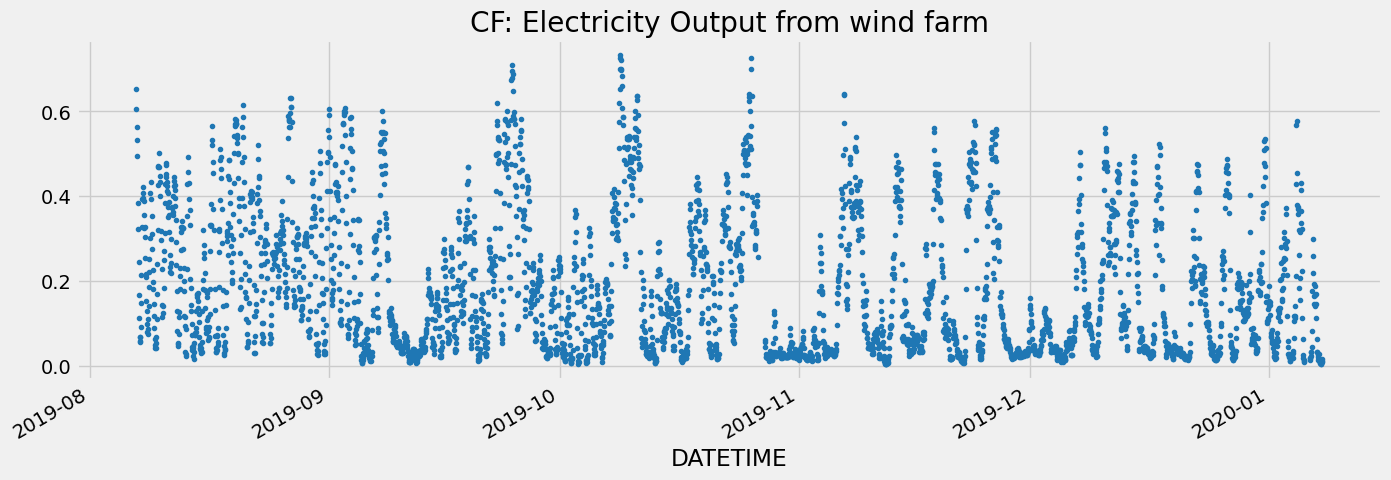

In [10]:
df[response_var].plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='CF: Electricity Output from wind farm')
plt.show()

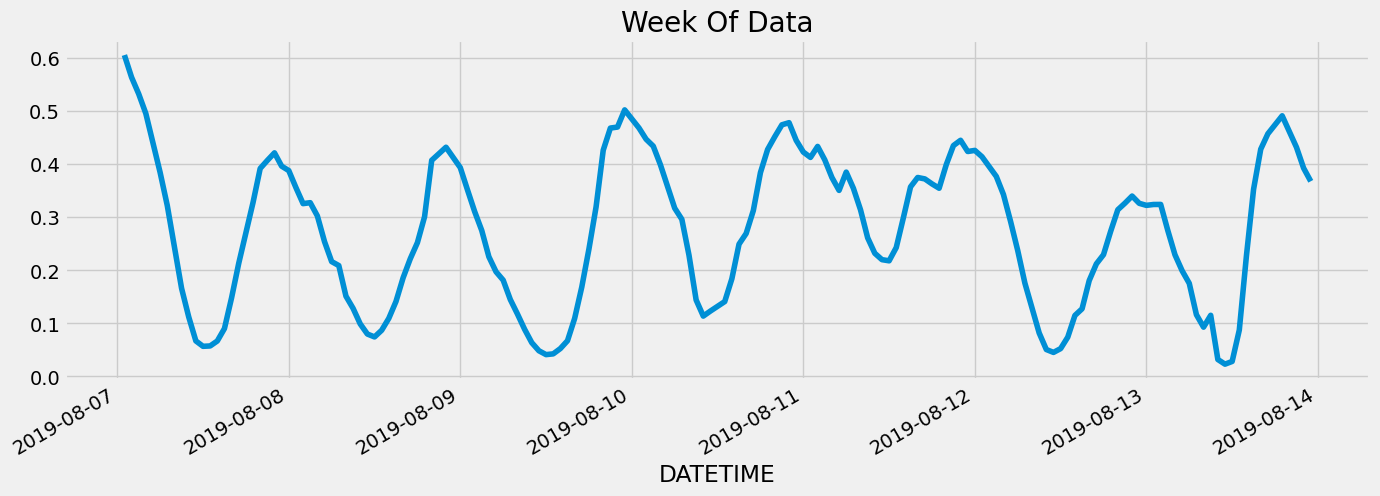

In [11]:
# Looking at just 1 week of data to try and understand trends
date_str_begin = df.index.min()
date_str_end = df.index.min() + pd.Timedelta(days=7)
df[response_var].loc[(df.index > date_str_begin) & (df.index < date_str_end)] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

The trends appears to be daily ie. every 24 hours

In [12]:
corr = df.corr()
corr

CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
CF          1.000000    0.724801    0.710433    0.170152    0.428863   
WS_1133733  0.724801    1.000000    0.985250    0.093646    0.686344   
WS_1156770  0.710433    0.985250    1.000000    0.098417    0.648143   
WS_1156968  0.170152    0.093646    0.098417    1.000000    0.082770   
WS_1182195  0.428863    0.686344    0.648143    0.082770    1.000000   
...              ...         ...         ...         ...         ...   
WS_883699   0.704502    0.982857    0.951172    0.120650    0.735884   
WS_914573   0.579387    0.802751    0.765396    0.105214    0.934309   
WS_918665   0.811993    0.572185    0.560684    0.164981    0.472534   
WS_920775   0.757800    0.557232    0.540939    0.163066    0.518533   
WS_921049   0.726670    0.530611    0.506068    0.190156    0.521042   

            WS_1193865  WS_1321569  WS_1324653  WS_1358699  WS_1366338  ...  \
CF            0.594679    0.227482    0.417947   -0.169850    0.596089  ...   
WS_1133733    0.476048    0.328725    0.255731   -0.013081    0.469620  ...   
WS_1156770    0.499236    0.336916    0.275703   -0.009782    0.496980  ...   
WS_1156968    0.251306    0.061329    0.321191    0.132907    0.257602  ...   
WS_1182195    0.113371    0.325802    0.158332    0.298286    0.098624  ...   
...                ...         ...         ...         ...         ...  ...   
WS_883699     0.446078    0.353438    0.254178    0.071334    0.432541  ...   
WS_914573     0.233872    0.319011    0.220036    0.129267    0.227081  ...   
WS_918665     0.364441    0.243132    0.397946   -0.038026    0.365625  ...   
WS_920775     0.312791    0.322186    0.362466    0.109579    0.299610  ...   
WS_921049     0.286014    0.325550    0.354097    0.074670    0.267745  ...   

            WS_78208  WS_811655  WS_839753  WS_875373  WS_883683  WS_883699  \
CF          0.720730   0.477331   0.777407   0.674839   0.823975   0.704502   
WS_1133733  0.977686   0.383380   0.605827   0.520335   0.585449   0.982857   
WS_1156770  0.936457   0.353987   0.592340   0.535498   0.581282   0.951172   
WS_1156968  0.094072   0.196005   0.146150   0.162616   0.149913   0.120650   
WS_1182195  0.742120   0.520854   0.519008   0.145412   0.437179   0.735884   
...              ...        ...        ...        ...        ...        ...   
WS_883699   0.984297   0.444009   0.619312   0.481247   0.574338   1.000000   
WS_914573   0.843784   0.471507   0.568945   0.290998   0.522104   0.828129   
WS_918665   0.596020   0.709479   0.928278   0.437765   0.984448   0.570079   
WS_920775   0.593694   0.811089   0.981908   0.365620   0.931039   0.575591   
WS_921049   0.580095   0.892618   0.904714   0.342674   0.878944   0.556787   

            WS_914573  WS_918665  WS_920775  WS_921049  
CF           0.579387   0.811993   0.757800   0.726670  
WS_1133733   0.802751   0.572185   0.557232   0.530611  
WS_1156770   0.765396   0.560684   0.540939   0.506068  
WS_1156968   0.105214   0.164981   0.163066   0.190156  
WS_1182195   0.934309   0.472534   0.518533   0.521042  
...               ...        ...        ...        ...  
WS_883699    0.828129   0.570079   0.575591   0.556787  
WS_914573    1.000000   0.543307   0.554357   0.550749  
WS_918665    0.543307   1.000000   0.949290   0.933567  
WS_920775    0.554357   0.949290   1.000000   0.939755  
WS_921049    0.550749   0.933567   0.939755   1.000000  

[113 rows x 113 columns]

In [13]:
corr_pairs = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool)).stack().reset_index()
corr_pairs.columns = ['Variable1', 'Variable2', 'Correlation']

n = 50

top_n_corr = corr_pairs.assign(AbsCorrelation=corr_pairs['Correlation'].abs()).sort_values('AbsCorrelation', ascending=False).head(n)

top_n_corr = top_n_corr.drop('AbsCorrelation', axis=1)

print(top_n_corr)

       Variable1   Variable2  Correlation
5814    WS_75932    WS_77682     1.000000
4088  WS_2508545    WS_75936     0.999998
5105    WS_73494    WS_74022     0.999947
3176  WS_2118117  WS_2479342     0.999922
5624    WS_74884   WS_921049     0.999904
4961    WS_72733   WS_746023     0.999885
5752    WS_75812    WS_77740     0.999880
5710    WS_75287    WS_76888     0.999860
1575  WS_1513782  WS_1513805     0.999858
5342    WS_74158    WS_74719     0.999818
5197    WS_73822   WS_918665     0.999762
4970    WS_72733    WS_75933     0.999716
2051  WS_1625374  WS_1681085     0.999661
5902    WS_75935    WS_77363     0.999659
1254  WS_1369320    WS_76434     0.999616
4966    WS_72733    WS_75287     0.999485
5516   WS_746023    WS_75933     0.999475
2967  WS_1960535    WS_74719     0.999394
4512   WS_629020    WS_74124     0.999383
5175    WS_73822    WS_76275     0.999254
3265  WS_2217107   WS_631992     0.999149
6175    WS_77682    WS_77683     0.999109
5815    WS_75932    WS_77683     0

There appears to be some very highly correlated variables among these Wind Speed measurements from different locations.

## Feature Engineering

One technique that I like to use, that I find works better than removing correlated features, is to combine the nuance of all of these correlated features by feeding them in a decision tree. Typically, this will uncover relationships in the data that we may not have discovered by another more traditional dimension reduction method.

First iteration of the baseline model: No tuning

In [14]:
# Feature Engineering: Add correlated variables to a decision tree that predicts the output
df.sort_index(inplace=True)
X = df.drop(response_var, axis=1)  # All columns except 'y'
y = df[response_var]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

decision_tree = DecisionTreeRegressor(
    random_state=42
)

decision_tree.fit(X_train, y_train)

decision_tree


DecisionTreeRegressor(random_state=42)

In [15]:
y_test_pred = decision_tree.predict(X_test)

test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")

Test MSE: 0.004036989335835169
Test MAE: 0.04047694419211


In [16]:
from sklearn.model_selection import cross_val_score, KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(decision_tree, X, y, cv=cv, scoring='neg_mean_squared_error')

mean_mse = np.mean(scores)
std_mse = np.std(scores)

print(f"Mean MSE: {mean_mse}")
print(f"Standard Deviation of MSE: {std_mse}")

Mean MSE: -0.004334875106144365
Standard Deviation of MSE: 0.00036071832552817353


Let's see if we can improve the performance via hyperparameter tuning with grid search:

In [17]:
dtree = DecisionTreeRegressor(random_state=42)

param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': [None,'sqrt', 'log2'] # removed 'auto'
}

grid_search = GridSearchCV(
    estimator=dtree,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1, 
    error_score='raise'
)

try:
    grid_search.fit(X_train, y_train)
except ValueError as e:
    print(f"Error during grid search: {e}")

best_dtree = grid_search.best_estimator_

y_pred_test = best_dtree.predict(X_test)
test_error = mean_squared_error(y_test, y_pred_test)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Test MSE: {test_error}") # using mse with this model since it is more sensitive to large outliers

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2}
Test MSE: 0.003982414077516889


In [18]:
y_test_pred = y_pred_test
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")

Test MSE: 0.003982414077516889
Test MAE: 0.04329218836506834


In [19]:
y_pred_all = best_dtree.predict(X)
y_pred_all_df = pd.Series(y_pred_all, index=y.index)
y_pred_all_df

DATETIME
2019-08-07 00:00:00    0.666727
2019-08-07 01:00:00    0.666727
2019-08-07 02:00:00    0.501278
2019-08-07 03:00:00    0.501278
2019-08-07 04:00:00    0.501278
                         ...   
2020-01-07 19:00:00    0.016742
2020-01-07 20:00:00    0.016742
2020-01-07 21:00:00    0.016742
2020-01-07 22:00:00    0.016742
2020-01-07 23:00:00    0.016742
Length: 3635, dtype: float64

In [20]:
assert y.shape[0] == y_pred_all_df.shape[0]

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='CF'>)

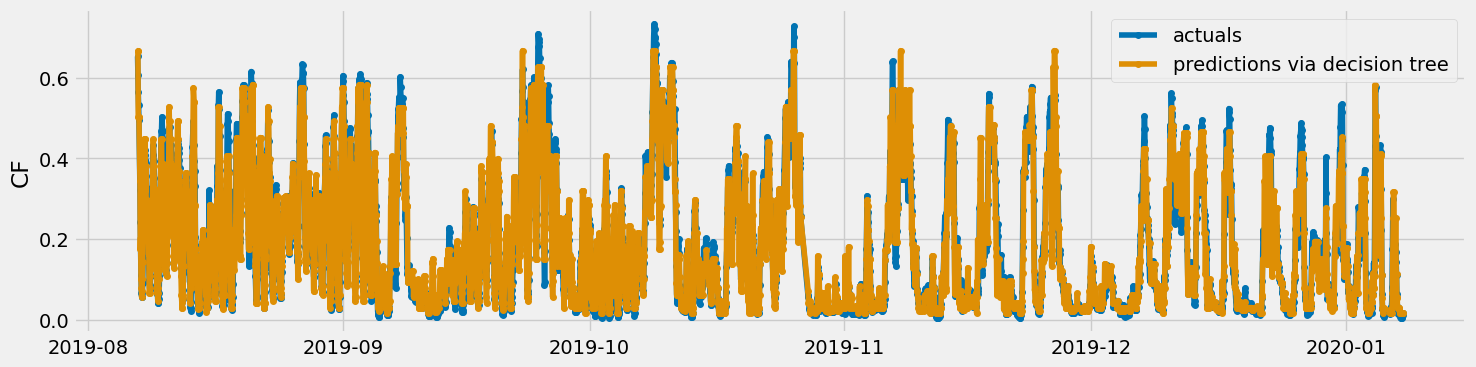

In [21]:
from sktime.utils.plotting import plot_series

plot_series(
    y,
    y_pred_all_df,
    labels=['actuals', 'predictions via decision tree', ]
)

This decision tree is doing a solid job of mapping the different measurements of wind to the hourly electricity output from a wind farm.

Here is the decision tree visualized, which is very helpful for model explainability/communicating with non-technical audiences due to its binary nature:

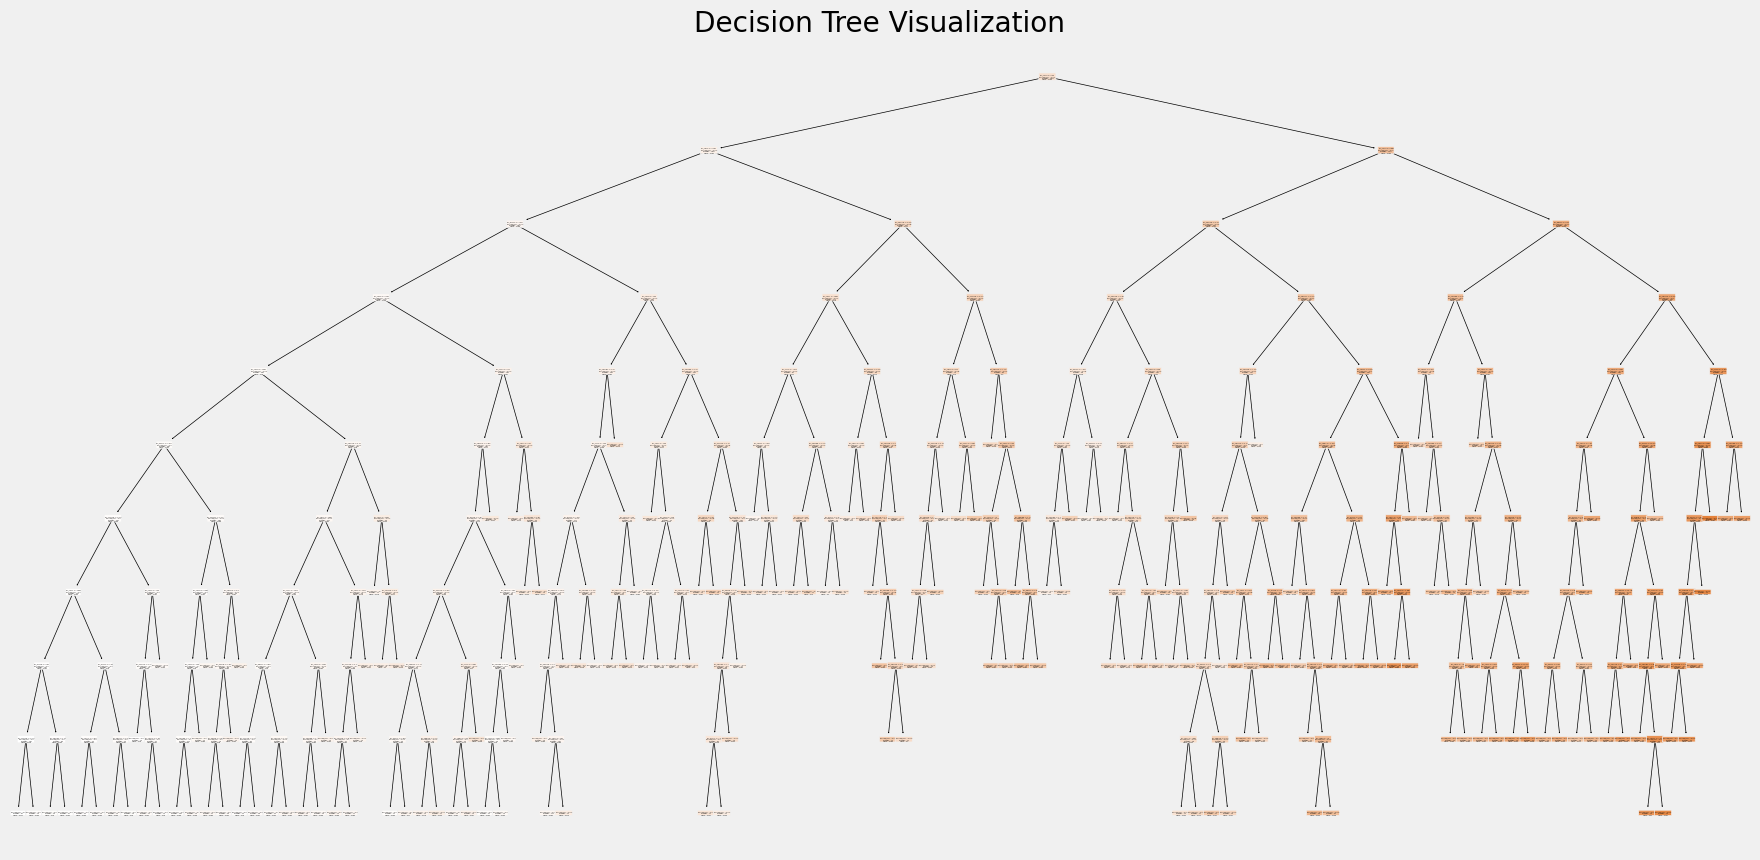

In [22]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))  # Set the figure size (width, height) in inches
plot_tree(best_dtree, filled=True, feature_names=list(X.columns), rounded=True)
plt.title("Decision Tree Visualization")
plt.show()


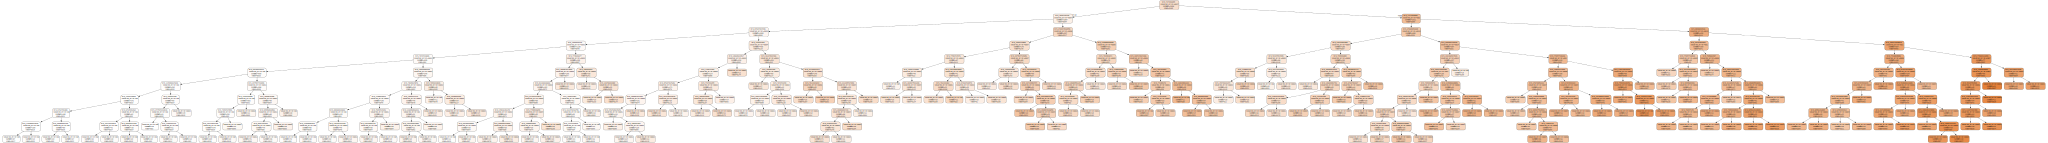

In [23]:
from sklearn.tree import export_graphviz
import graphviz

# Export as dot file
dot_data = export_graphviz(best_dtree, out_file=None, 
                           feature_names=X.columns,
                           filled=True, rounded=True,  
                           special_characters=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph


I will try to optimize this ensemble model even further by branching into models other than the decision tree. Namely, ...

In [24]:
# PyCaret for automated ML
# pip install pycaret[full] to make sure that all models run
# note; has some dependency issues with sktime, may want to pip download this THEN sktime
from pycaret.regression import setup, compare_models, evaluate_model, predict_model, save_model, load_model

In [25]:
# create an experiment
s = setup(df, target=response_var)

In [26]:
best_model = compare_models() # search for best model

In [27]:
evaluate_model(best_model) # check performance, look at hyperparams/feature importance

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [28]:
y_pred = predict_model(best_model, data=X_test) # make predictions

In [29]:
y_pred['prediction_label']

DATETIME
2019-09-30 14:00:00    0.048241
2019-08-12 07:00:00    0.142627
2019-09-11 20:00:00    0.043356
2019-10-10 22:00:00    0.565252
2019-12-07 06:00:00    0.317705
                         ...   
2019-08-21 19:00:00    0.371322
2019-10-15 17:00:00    0.065840
2019-10-13 05:00:00    0.037690
2019-09-05 03:00:00    0.102176
2019-10-23 04:00:00    0.215145
Name: prediction_label, Length: 727, dtype: float64

In [30]:
test_mse = mean_squared_error(y_test, y_pred['prediction_label'])
test_mae = mean_absolute_error(y_test, y_pred['prediction_label'])

print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")

Test MSE: 0.0004666386071412701
Test MAE: 0.013771945029450791


In [31]:
# save model for use later
save_model(best_model, os.path.join(INTER_DIR, "optimal_model"))


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['WS_1133733', 'WS_1156770',
                                              'WS_1156968', 'WS_1182195',
                                              'WS_1193865', 'WS_1321569',
                                              'WS_1324653', 'WS_1358699',
                                              'WS_1366338', 'WS_1366351',
                                              'WS_1369320', 'WS_1461024',
                                              'WS_1481513', 'WS_1504146',
                                              'WS_1513782', 'WS_1513805',
                                              'WS_1571308', 'WS_1574484',
                                              'WS_1625339', 'WS_16253...
                                              'WS_1628663', 'WS_1681085',
                                              'WS_1820276', 'WS_1820279',
                                  

In [32]:
# check that loading works (will need to load it later, so testing now)
model = load_model(os.path.join(INTER_DIR, "optimal_model"))
model

Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=FastMemory(location=C:\Users\Myles\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['WS_1133733', 'WS_1156770',
                                             'WS_1156968', 'WS_1182195',
                                             'WS_1193865', 'WS_1321569',
                                             'WS_1324653', 'WS_1358699',
                                             'WS_1366338', 'WS_1366351',
                                             'WS_1369320', 'WS_1461024',
                                             'WS_1481513', 'WS_1504146',
                                             'WS_1513782', 'WS_1513805',
                                             'WS_1571...
                                             'WS_1628663', 'WS_1681085',
                                             'WS_1820276', 'WS_1820279',
                                             'WS_1899876', 'WS_1911282',
                                             'WS_1937650', 'WS_1937653',
                                             'WS_1953863', 'WS_1960535', ...],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('trained_model',
                 <catboost.core.CatBoostRegressor object at 0x00000288B70D5C10>)])

In [33]:
y_pred_all = model.predict(X)
y_pred_all_df = pd.Series(y_pred_all, index=y.index)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='CF'>)

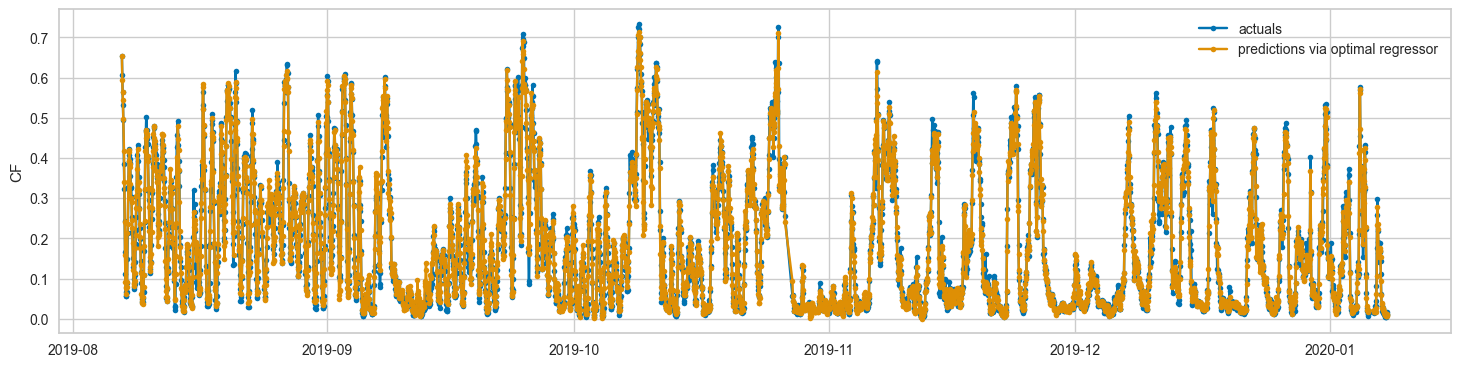

In [34]:
plot_series(
    y,
    y_pred_all_df,
    labels=['actuals', 'predictions via optimal regressor', ]
)

## More Feature Engineering and EDA

Looking at features that can be derived from dates:

In [35]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    # Ensure the index is of datetime type
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    # df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek # 0=Monday, 6=Sunday
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    
    # Add holidays
    df = add_holiday_flags(df, country='US')
    return df

In [36]:
df = df[response_var].to_frame()

df['prediction_wind_decision_tree'] = pd.Series(y_pred_all, index=y.index)

df = create_features(df)

df.head()

CF  prediction_wind_decision_tree  hour  dayofweek  \
2019-08-07 00:00:00  0.652524                       0.652568     0          2   
2019-08-07 01:00:00  0.605852                       0.594954     1          2   
2019-08-07 02:00:00  0.564094                       0.563370     2          2   
2019-08-07 03:00:00  0.532721                       0.543258     3          2   
2019-08-07 04:00:00  0.495608                       0.496438     4          2   

                     quarter  month  year  dayofyear  dayofmonth  weekofyear  \
2019-08-07 00:00:00        3      8  2019        219           7          32   
2019-08-07 01:00:00        3      8  2019        219           7          32   
2019-08-07 02:00:00        3      8  2019        219           7          32   
2019-08-07 03:00:00        3      8  2019        219           7          32   
2019-08-07 04:00:00        3      8  2019        219           7          32   

                     is_holiday holiday_name  
2019-08-07 00:00:00           0         None  
2019-08-07 01:00:00           0         None  
2019-08-07 02:00:00           0         None  
2019-08-07 03:00:00           0         None  
2019-08-07 04:00:00           0         None

## Visualize our Feature / Target Relationship

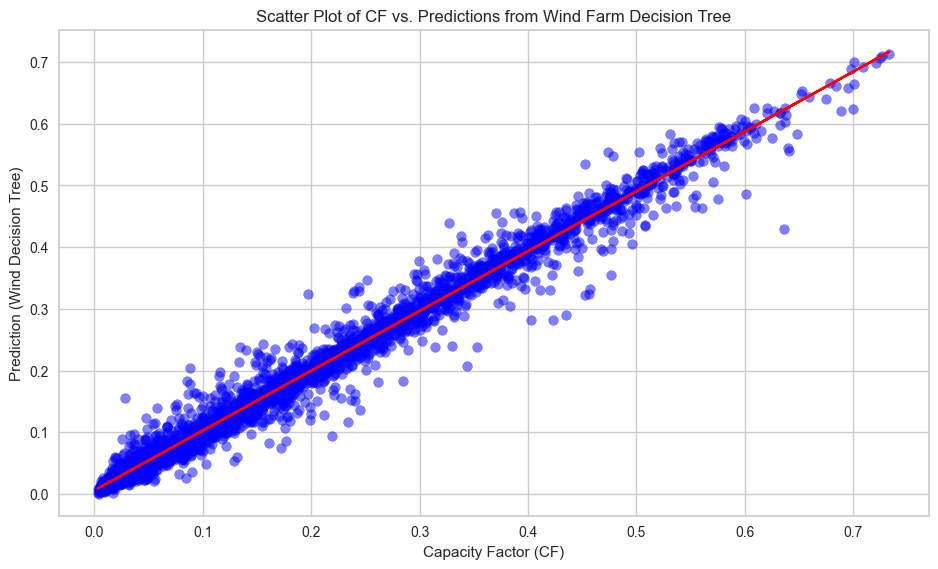

In [37]:
plt.figure(figsize=(10, 6))
plt.scatter(df['CF'], df['prediction_wind_decision_tree'], color='blue', alpha=0.5)
m, b = np.polyfit(df['CF'], df['prediction_wind_decision_tree'], 1)
plt.plot(df['CF'], m*df['CF'] + b, color='red')  # Add the line equation
plt.title('Scatter Plot of CF vs. Predictions from Wind Farm Decision Tree')
plt.xlabel('Capacity Factor (CF)')
plt.ylabel('Prediction (Wind Decision Tree)')
plt.grid(True)
plt.show()

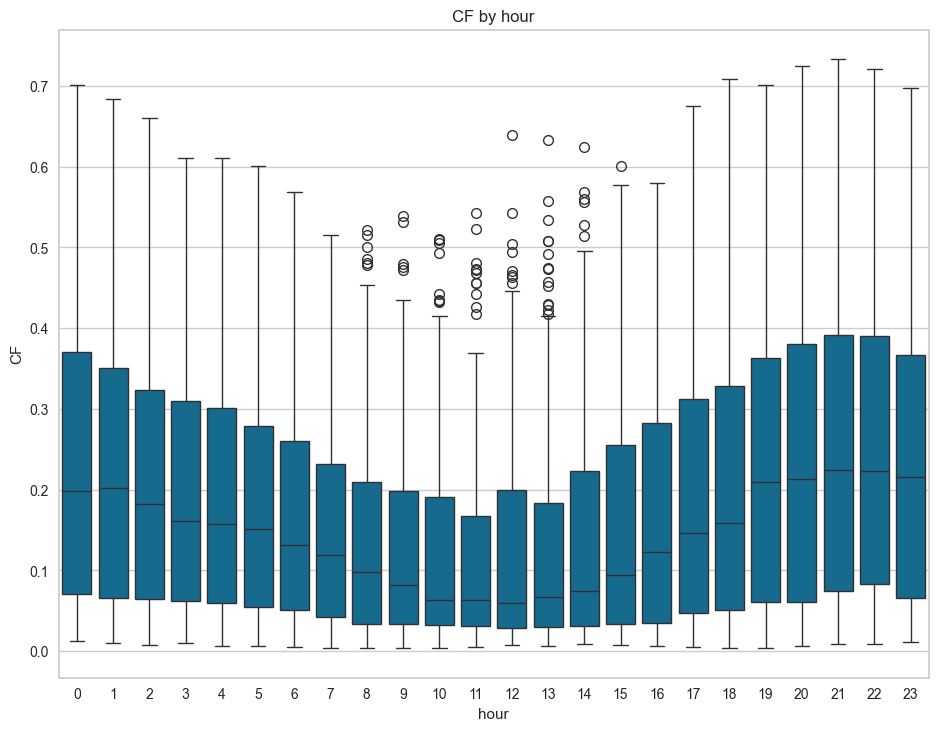

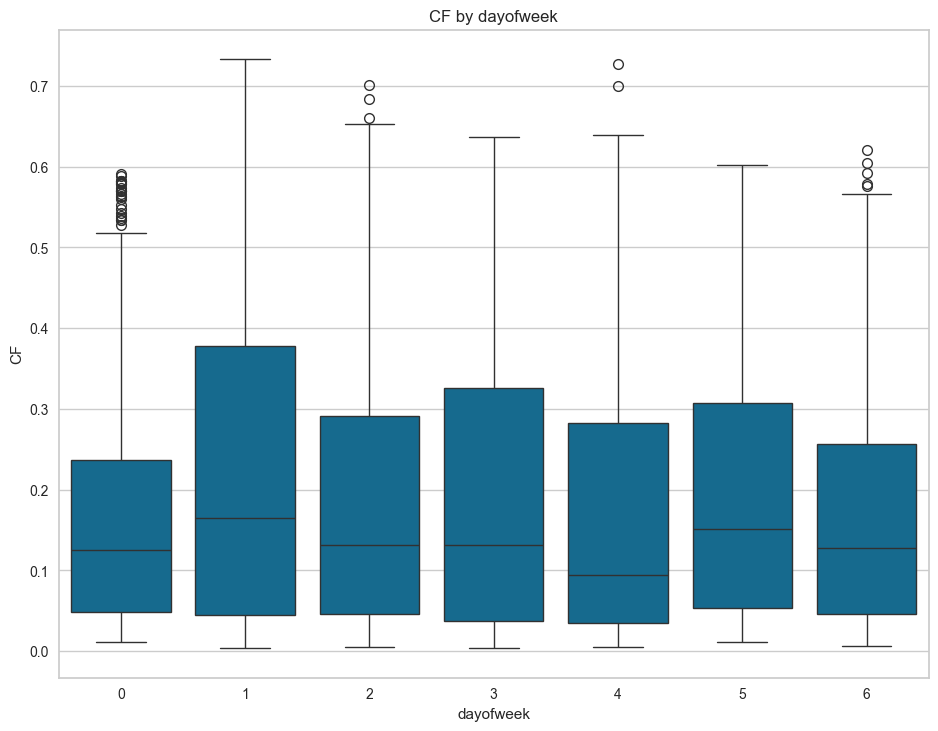

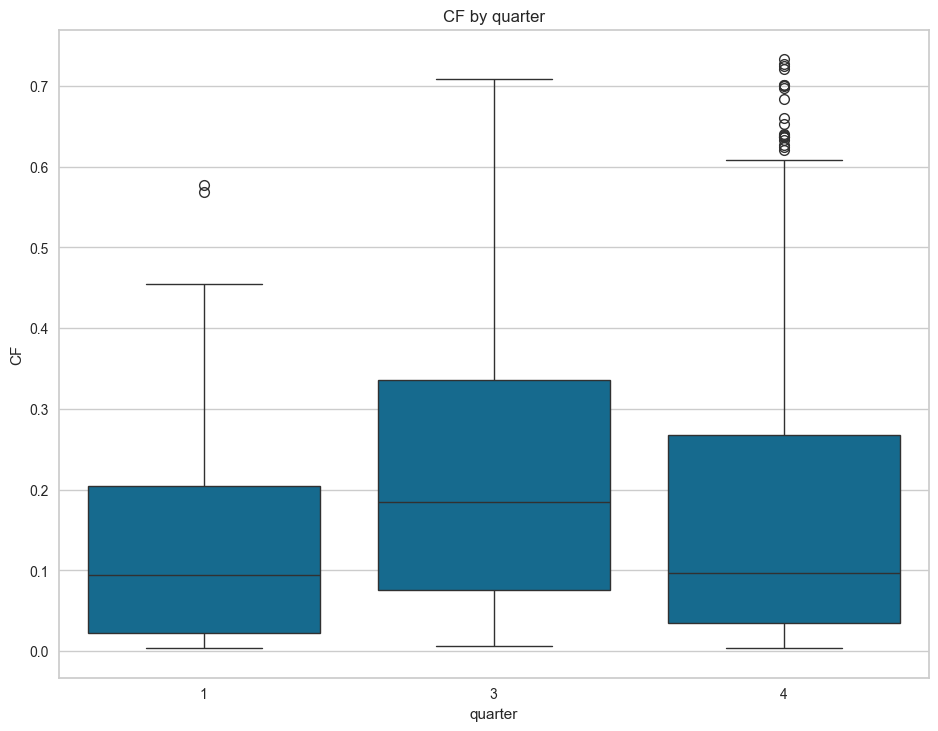

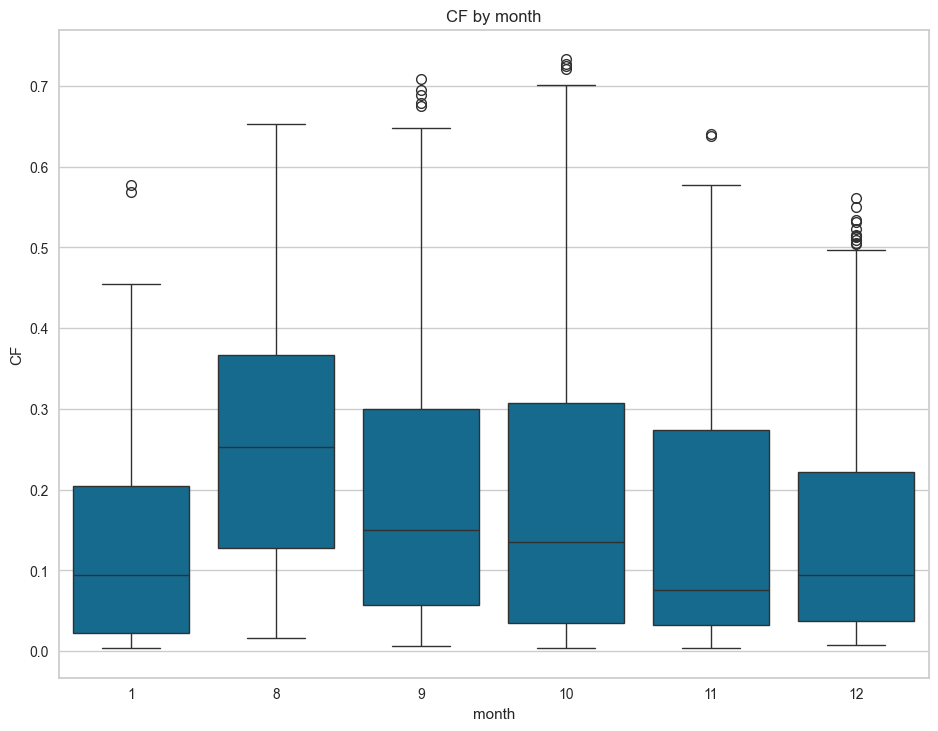

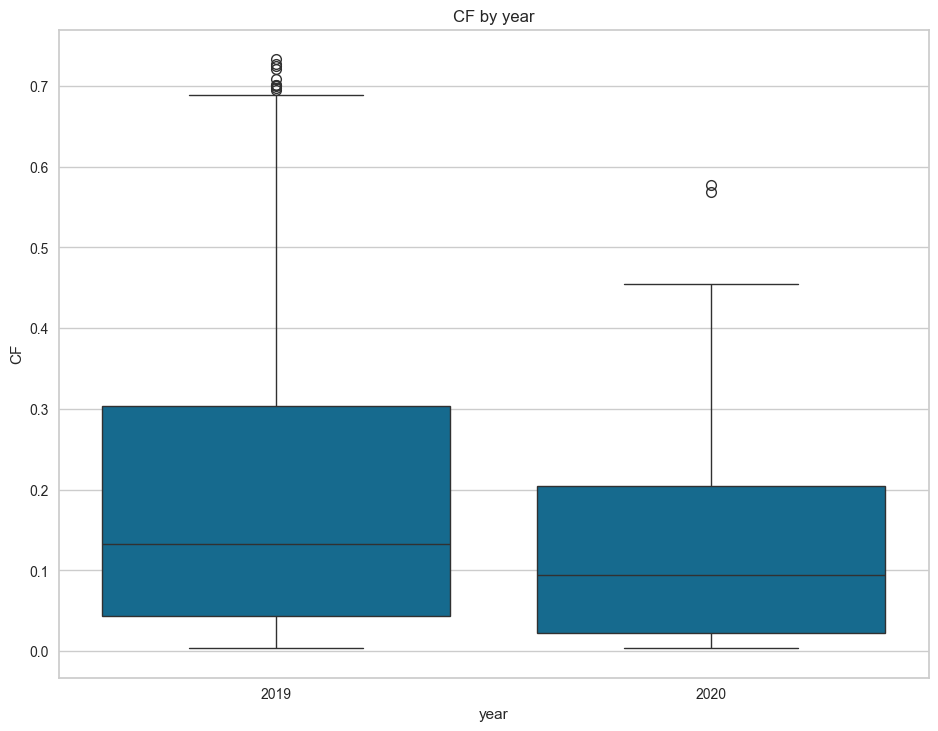

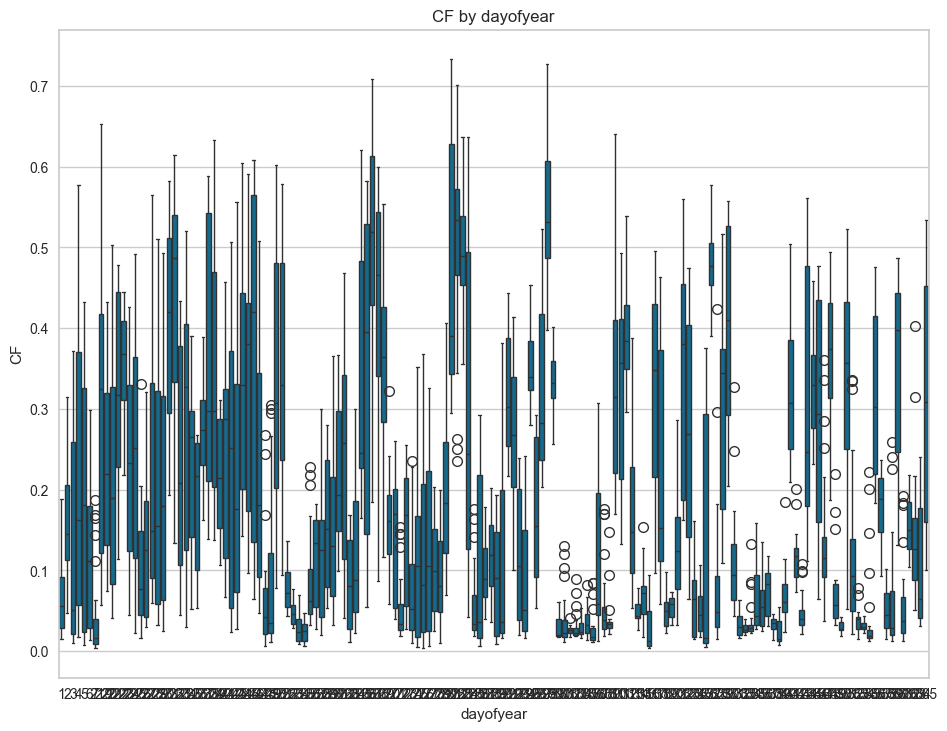

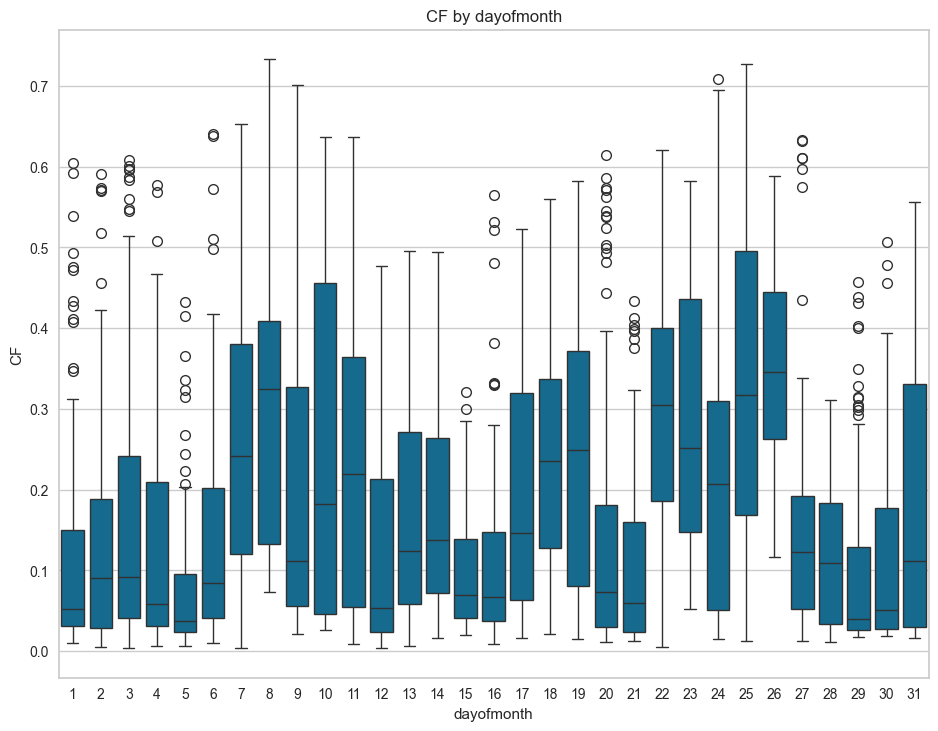

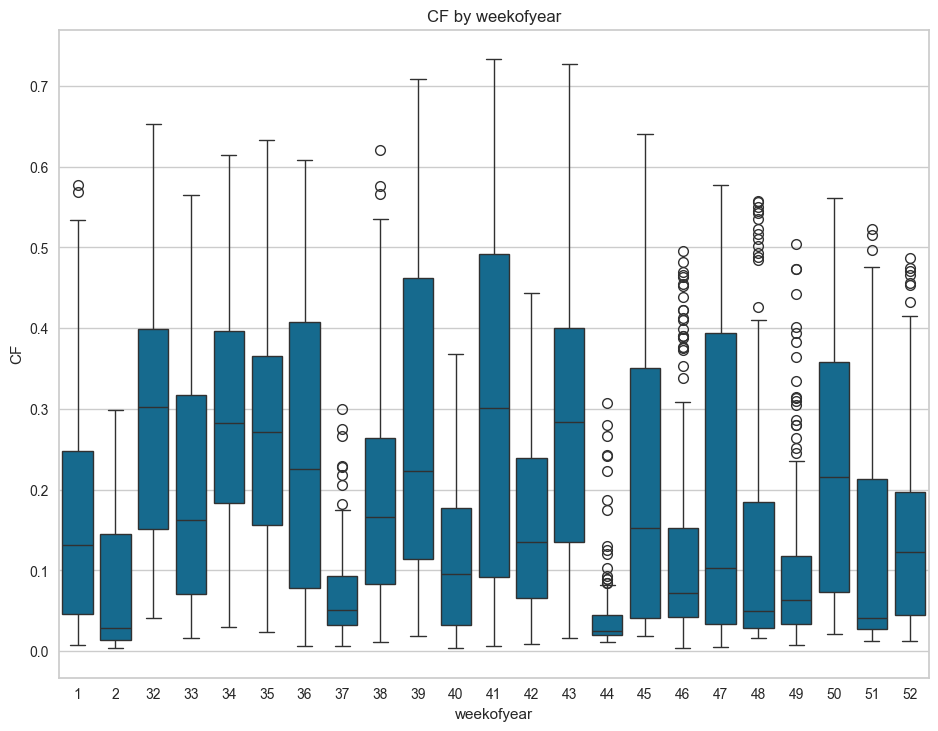

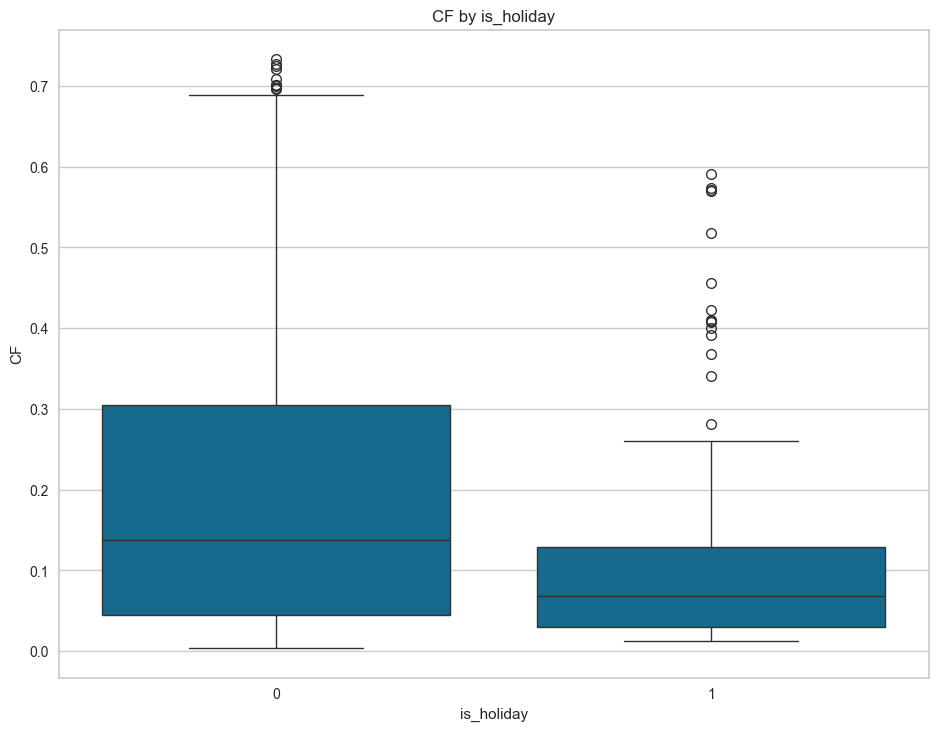

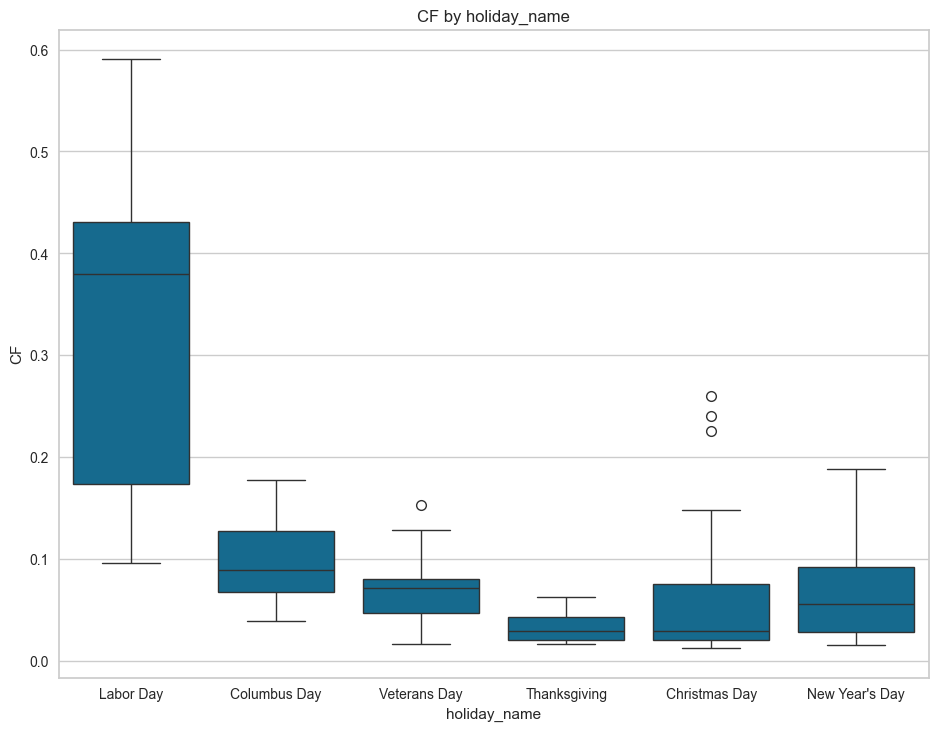

In [38]:
for column in df.columns:
    if column not in [response_var, 'prediction_wind_decision_tree']:
        predictor = column
        fig, ax = plt.subplots(figsize=(10, 8))
        sns.boxplot(data=df, x=predictor, y=response_var)
        ax.set_title(f'{response_var} by {predictor}')
        plt.show()

Notable trends:
- prediction_wind_decision_tree: The wind farm decision tree does a pretty good job of mapping to the Average electricity output
- hour: Average electricity output appears to follow a trend where it is higher during the morning, dips during the afternoon, and increases again in the evening (this is intuitive with human behavior)
- quarter: Average electricity output appears to be higher in quarter 3 (unclear why)
- month: Average electricity output spikes in August
- year: Average electricity output is higher in 2019 (note: we just don't have much data on 2020 yet)
- dayofmonth: Average electricity output is quite erratic, I am also not sure if this is intuitive given that the day of the month shouldn't affect human behavior in the way that dayofweek may
- weekofyear: Similar story
- is_holiday: Average electricity output is noticeably lower on holidays
- holiday_name: Of the holiday's labor day bucks this trend with an extremely high Average electricity output

In [39]:
# get dummy variables for holiday
df = pd.get_dummies(df)
del df['is_holiday']

df

CF  prediction_wind_decision_tree  hour  dayofweek  \
2019-08-07 00:00:00  0.652524                       0.652568     0          2   
2019-08-07 01:00:00  0.605852                       0.594954     1          2   
2019-08-07 02:00:00  0.564094                       0.563370     2          2   
2019-08-07 03:00:00  0.532721                       0.543258     3          2   
2019-08-07 04:00:00  0.495608                       0.496438     4          2   
...                       ...                            ...   ...        ...   
2020-01-07 19:00:00  0.004494                       0.008086    19          1   
2020-01-07 20:00:00  0.006143                       0.011182    20          1   
2020-01-07 21:00:00  0.008399                       0.010250    21          1   
2020-01-07 22:00:00  0.015788                       0.012990    22          1   
2020-01-07 23:00:00  0.011883                       0.007626    23          1   

                     quarter  month  year  dayofyear  dayofmonth  weekofyear  \
2019-08-07 00:00:00        3      8  2019        219           7          32   
2019-08-07 01:00:00        3      8  2019        219           7          32   
2019-08-07 02:00:00        3      8  2019        219           7          32   
2019-08-07 03:00:00        3      8  2019        219           7          32   
2019-08-07 04:00:00        3      8  2019        219           7          32   
...                      ...    ...   ...        ...         ...         ...   
2020-01-07 19:00:00        1      1  2020          7           7           2   
2020-01-07 20:00:00        1      1  2020          7           7           2   
2020-01-07 21:00:00        1      1  2020          7           7           2   
2020-01-07 22:00:00        1      1  2020          7           7           2   
2020-01-07 23:00:00        1      1  2020          7           7           2   

                     holiday_name_Christmas Day  holiday_name_Columbus Day  \
2019-08-07 00:00:00                       False                      False   
2019-08-07 01:00:00                       False                      False   
2019-08-07 02:00:00                       False                      False   
2019-08-07 03:00:00                       False                      False   
2019-08-07 04:00:00                       False                      False   
...                                         ...                        ...   
2020-01-07 19:00:00                       False                      False   
2020-01-07 20:00:00                       False                      False   
2020-01-07 21:00:00                       False                      False   
2020-01-07 22:00:00                       False                      False   
2020-01-07 23:00:00                       False                      False   

                     holiday_name_Labor Day  holiday_name_New Year's Day  \
2019-08-07 00:00:00                   False                        False   
2019-08-07 01:00:00                   False                        False   
2019-08-07 02:00:00                   False                        False   
2019-08-07 03:00:00                   False                        False   
2019-08-07 04:00:00                   False                        False   
...                                     ...                          ...   
2020-01-07 19:00:00                   False                        False   
2020-01-07 20:00:00                   False                        False   
2020-01-07 21:00:00                   False                        False   
2020-01-07 22:00:00                   False                        False   
2020-01-07 23:00:00                   False                        False   

                     holiday_name_Thanksgiving  holiday_name_Veterans Day  
2019-08-07 00:00:00                      False                      False  
2019-08-07 01:00:00                      False                      False  
2019-08-07 02:0

Before ML modeling, we need to make sure to have a true hourly dataset ie. a row of data at each hourly interval.

In [40]:
time_diffs = df.index.to_series().diff().unique()
print(time_diffs)

<TimedeltaArray>
[              NaT, '0 days 01:00:00', '0 days 02:00:00', '0 days 03:00:00',
 '0 days 07:00:00', '0 days 22:00:00', '0 days 17:00:00']
Length: 7, dtype: timedelta64[ns]


The only differences between rows of data should be NA (beginning and end), and 1 hour (all data in between), so this is something we need to fix.

In [41]:
import pandas as pd

def ensure_hourly_frequency(df):
    """
    Reindexes a DataFrame to ensure it has an hourly frequency, filling any missing timestamps.

    This function calculates the minimum and maximum datetime indices of the DataFrame, 
    creates a new DateTimeIndex with hourly intervals within this range, and reindexes 
    the DataFrame using this hourly index. Missing data points are forward-filled to avoid data leakage.

    Parameters:
    df (pd.DataFrame): DataFrame with a DateTimeIndex that needs to be set to a regular hourly frequency.

    Returns:
    pd.DataFrame: The reindexed DataFrame with hourly frequency, where missing data points have been forward-filled.
    """
    # Calculate the start and end of the DataFrame's index
    start = df.index.min()
    end = df.index.max()
    print(start, end)

    # Create a full hourly DateTimeIndex from start to end
    full_index = pd.date_range(start=start, end=end, freq='H')

    # Reindex the DataFrame to this new index, forward filling missing values
    # df = df.reindex(full_index, method='ffill')
    df = df.reindex(full_index, method=None)

    return df

df = ensure_hourly_frequency(df=df)


2019-08-07 00:00:00 2020-01-07 23:00:00


In [42]:
time_diffs = df.index.to_series().diff().unique()
print(time_diffs)

<TimedeltaArray>
[NaT, '0 days 01:00:00']
Length: 2, dtype: timedelta64[ns]


We just introduced NA into our dataset. Because we do not have prediction data for wind model for every timestamp, we are going to have to forward fill the values from the wind prediction model and the response variable (`CF`).

As you have seen during the EDA section, the data follows a daily/weekly trends, so I will try out using the past day's information first.

In [43]:
df.index

DatetimeIndex(['2019-08-07 00:00:00', '2019-08-07 01:00:00',
               '2019-08-07 02:00:00', '2019-08-07 03:00:00',
               '2019-08-07 04:00:00', '2019-08-07 05:00:00',
               '2019-08-07 06:00:00', '2019-08-07 07:00:00',
               '2019-08-07 08:00:00', '2019-08-07 09:00:00',
               ...
               '2020-01-07 14:00:00', '2020-01-07 15:00:00',
               '2020-01-07 16:00:00', '2020-01-07 17:00:00',
               '2020-01-07 18:00:00', '2020-01-07 19:00:00',
               '2020-01-07 20:00:00', '2020-01-07 21:00:00',
               '2020-01-07 22:00:00', '2020-01-07 23:00:00'],
              dtype='datetime64[ns]', length=3696, freq='H')

In [44]:
print(f"number of NA values: {df['CF'].isna().sum()}")
print(f"number of NA values: {df['prediction_wind_decision_tree'].isna().sum()}")

number of NA values: 61
number of NA values: 61


In [45]:
# grabbing some indices to check how they were filled
indices_list = df[df['CF'].isna()].index
print(len(indices_list))

61


In [46]:
def custom_ffill(df, columns, hours_back):
    """
    Custom forward fill function that fills NaNs for multiple columns based on the value from 'hours_back' hours ago.
    Uses the datetime index directly.
    """
    time_delta = pd.Timedelta(hours=hours_back)
    
    for column in columns:
        # Apply a custom function to fill NaNs by looking 'hours_back'
        df[column] = df[column].combine_first(
            df.index.to_series().apply(lambda dt: df.at[dt - time_delta, column] if (dt - time_delta) in df.index else np.nan)
        )
    
    return df

# Forward fill based on the last day (24 hours back)
df = custom_ffill(df, list(df.columns), 24)


In [47]:
# Ensuring a value from before was filled with yesterday's value
idx = indices_list[25]
print(idx)

2019-10-26 21:00:00


In [48]:
time_delta = pd.Timedelta(hours=24)

idx_one_day_prior = idx - time_delta
print(idx_one_day_prior)

2019-10-25 21:00:00


In [49]:
# These should be the same data
df[df.index == idx]

CF  prediction_wind_decision_tree  hour  dayofweek  \
2019-10-26 21:00:00  0.726732                       0.709995  21.0        4.0   

                     quarter  month    year  dayofyear  dayofmonth  \
2019-10-26 21:00:00      4.0   10.0  2019.0      298.0        25.0   

                     weekofyear holiday_name_Christmas Day  \
2019-10-26 21:00:00          43                      False   

                    holiday_name_Columbus Day holiday_name_Labor Day  \
2019-10-26 21:00:00                     False                  False   

                    holiday_name_New Year's Day holiday_name_Thanksgiving  \
2019-10-26 21:00:00                       False                     False   

                    holiday_name_Veterans Day  
2019-10-26 21:00:00                     False

In [50]:
# These should be the same data
df[df.index == idx_one_day_prior]

CF  prediction_wind_decision_tree  hour  dayofweek  \
2019-10-25 21:00:00  0.726732                       0.709995  21.0        4.0   

                     quarter  month    year  dayofyear  dayofmonth  \
2019-10-25 21:00:00      4.0   10.0  2019.0      298.0        25.0   

                     weekofyear holiday_name_Christmas Day  \
2019-10-25 21:00:00          43                      False   

                    holiday_name_Columbus Day holiday_name_Labor Day  \
2019-10-25 21:00:00                     False                  False   

                    holiday_name_New Year's Day holiday_name_Thanksgiving  \
2019-10-25 21:00:00                       False                     False   

                    holiday_name_Veterans Day  
2019-10-25 21:00:00                     False

In [51]:
print(f"number of NA values: {df['CF'].isna().sum()}")
print(f"number of NA values: {df['prediction_wind_decision_tree'].isna().sum()}")

number of NA values: 2
number of NA values: 2


In [52]:
df[df['CF'].isna()]

CF  prediction_wind_decision_tree  hour  dayofweek  \
2019-08-07 05:00:00 NaN                            NaN   NaN        NaN   
2019-08-07 18:00:00 NaN                            NaN   NaN        NaN   

                     quarter  month  year  dayofyear  dayofmonth  weekofyear  \
2019-08-07 05:00:00      NaN    NaN   NaN        NaN         NaN        <NA>   
2019-08-07 18:00:00      NaN    NaN   NaN        NaN         NaN        <NA>   

                    holiday_name_Christmas Day holiday_name_Columbus Day  \
2019-08-07 05:00:00                        NaN                       NaN   
2019-08-07 18:00:00                        NaN                       NaN   

                    holiday_name_Labor Day holiday_name_New Year's Day  \
2019-08-07 05:00:00                    NaN                         NaN   
2019-08-07 18:00:00                    NaN                         NaN   

                    holiday_name_Thanksgiving holiday_name_Veterans Day  
2019-08-07 05:00:00                       NaN                       NaN  
2019-08-07 18:00:00                       NaN                       NaN

In [53]:
df.iloc[4:6]

CF  prediction_wind_decision_tree  hour  dayofweek  \
2019-08-07 04:00:00  0.495608                       0.496438   4.0        2.0   
2019-08-07 05:00:00       NaN                            NaN   NaN        NaN   

                     quarter  month    year  dayofyear  dayofmonth  \
2019-08-07 04:00:00      3.0    8.0  2019.0      219.0         7.0   
2019-08-07 05:00:00      NaN    NaN     NaN        NaN         NaN   

                     weekofyear holiday_name_Christmas Day  \
2019-08-07 04:00:00          32                      False   
2019-08-07 05:00:00        <NA>                        NaN   

                    holiday_name_Columbus Day holiday_name_Labor Day  \
2019-08-07 04:00:00                     False                  False   
2019-08-07 05:00:00                       NaN                    NaN   

                    holiday_name_New Year's Day holiday_name_Thanksgiving  \
2019-08-07 04:00:00                       False                     False   
2019-08-07 05:00:00                         NaN                       NaN   

                    holiday_name_Veterans Day  
2019-08-07 04:00:00                     False  
2019-08-07 05:00:00                       NaN

In [54]:
# Fill with value from the hour beforehand if we don't have data from a week ago
# (ie. this value in the 7th row doesn't have anything to look back at, so we will use the previous hour's here)
if df['CF'].isna().sum() > 0:
    print(f"filled {df['CF'].isna().sum()} values via forward fill from last hour")
    df = df.fillna(method="ffill")

filled 2 values via forward fill from last hour


In [55]:
# 6th row was filled with info from row 5
df.iloc[4:6]

CF  prediction_wind_decision_tree  hour  dayofweek  \
2019-08-07 04:00:00  0.495608                       0.496438   4.0        2.0   
2019-08-07 05:00:00  0.495608                       0.496438   4.0        2.0   

                     quarter  month    year  dayofyear  dayofmonth  \
2019-08-07 04:00:00      3.0    8.0  2019.0      219.0         7.0   
2019-08-07 05:00:00      3.0    8.0  2019.0      219.0         7.0   

                     weekofyear  holiday_name_Christmas Day  \
2019-08-07 04:00:00          32                       False   
2019-08-07 05:00:00          32                       False   

                     holiday_name_Columbus Day  holiday_name_Labor Day  \
2019-08-07 04:00:00                      False                   False   
2019-08-07 05:00:00                      False                   False   

                     holiday_name_New Year's Day  holiday_name_Thanksgiving  \
2019-08-07 04:00:00                        False                      False   
2019-08-07 05:00:00                        False                      False   

                     holiday_name_Veterans Day  
2019-08-07 04:00:00                      False  
2019-08-07 05:00:00                      False

In [56]:
print(f"number of NA values: {df['CF'].isna().sum()}")
print(f"number of NA values: {df['prediction_wind_decision_tree'].isna().sum()}")

number of NA values: 0
number of NA values: 0


In [57]:
time_diffs = df.index.to_series().diff().unique()
print(time_diffs)

<TimedeltaArray>
[NaT, '0 days 01:00:00']
Length: 2, dtype: timedelta64[ns]


In [58]:
def prepare_data_for_sktime(df):
    """
    Converts numerical columns in the provided DataFrame to float64, 
    a format compatible with sktime forecasting models.

    This function iterates through each column in the DataFrame, checking the data type. 
    If the data type of a column is either UInt32 or Float64, it converts the column to float64.
    This ensures that all numerical data is in a consistent format expected by sktime models.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the data to be prepared.

    Returns:
    pandas.DataFrame: The DataFrame with numerical columns converted to float64.
    
    Prints:
    The name of each column that is converted, along with its data type before and after conversion.
    """
    for column_name, column_dtype in zip(df.columns, df.dtypes):
        if column_dtype in ["UInt32", "Float64"]:
            print(column_name)
            print(f"before: {column_dtype}")
            df[column_name] = df[column_name].astype('float64')
            print(f"after: {df[column_name].dtype}")
    
    return df

def boolean_to_binary(dataframe):
    """
    Converts all boolean columns in a DataFrame to binary numeric format (0s and 1s).

    Args:
        dataframe (pd.DataFrame): The DataFrame containing boolean columns.

    Returns:
        pd.DataFrame: A DataFrame with boolean columns converted to binary numeric format.
    """
    # Copy the DataFrame to avoid altering the original data
    df = dataframe.copy()
    # Select boolean columns and convert them
    boolean_cols = df.select_dtypes(include=['bool']).columns
    df[boolean_cols] = df[boolean_cols].astype(int)
    return df

df = prepare_data_for_sktime(df)
df = boolean_to_binary(df)

print(df.dtypes)
df.head()

weekofyear
before: UInt32
after: float64
CF                               float64
prediction_wind_decision_tree    float64
hour                             float64
dayofweek                        float64
quarter                          float64
month                            float64
year                             float64
dayofyear                        float64
dayofmonth                       float64
weekofyear                       float64
holiday_name_Christmas Day         int32
holiday_name_Columbus Day          int32
holiday_name_Labor Day             int32
holiday_name_New Year's Day        int32
holiday_name_Thanksgiving          int32
holiday_name_Veterans Day          int32
dtype: object


CF  prediction_wind_decision_tree  hour  dayofweek  \
2019-08-07 00:00:00  0.652524                       0.652568   0.0        2.0   
2019-08-07 01:00:00  0.605852                       0.594954   1.0        2.0   
2019-08-07 02:00:00  0.564094                       0.563370   2.0        2.0   
2019-08-07 03:00:00  0.532721                       0.543258   3.0        2.0   
2019-08-07 04:00:00  0.495608                       0.496438   4.0        2.0   

                     quarter  month    year  dayofyear  dayofmonth  \
2019-08-07 00:00:00      3.0    8.0  2019.0      219.0         7.0   
2019-08-07 01:00:00      3.0    8.0  2019.0      219.0         7.0   
2019-08-07 02:00:00      3.0    8.0  2019.0      219.0         7.0   
2019-08-07 03:00:00      3.0    8.0  2019.0      219.0         7.0   
2019-08-07 04:00:00      3.0    8.0  2019.0      219.0         7.0   

                     weekofyear  holiday_name_Christmas Day  \
2019-08-07 00:00:00        32.0                           0   
2019-08-07 01:00:00        32.0                           0   
2019-08-07 02:00:00        32.0                           0   
2019-08-07 03:00:00        32.0                           0   
2019-08-07 04:00:00        32.0                           0   

                     holiday_name_Columbus Day  holiday_name_Labor Day  \
2019-08-07 00:00:00                          0                       0   
2019-08-07 01:00:00                          0                       0   
2019-08-07 02:00:00                          0                       0   
2019-08-07 03:00:00                          0                       0   
2019-08-07 04:00:00                          0                       0   

                     holiday_name_New Year's Day  holiday_name_Thanksgiving  \
2019-08-07 00:00:00                            0                          0   
2019-08-07 01:00:00                            0                          0   
2019-08-07 02:00:00                            0                          0   
2019-08-07 03:00:00                            0                          0   
2019-08-07 04:00:00                            0                          0   

                     holiday_name_Veterans Day  
2019-08-07 00:00:00                          0  
2019-08-07 01:00:00                          0  
2019-08-07 02:00:00                          0  
2019-08-07 03:00:00                          0  
2019-08-07 04:00:00                          0

In [59]:
df.to_csv(os.path.join(INTER_DIR, "data_after_feature_engineering.csv"), index=True)


In [60]:
df = pd.read_csv(os.path.join(INTER_DIR, "data_after_feature_engineering.csv"), index_col=0)


In [61]:
print(df.index.dtype)
df.index = pd.to_datetime(df.index)
df.index.freq = 'H'
print(df.index.dtype)

object
datetime64[ns]


## Train / Test Split

Model 1 (baseline model) will use a train/test split.

The optimal model with optimized parameters will be selected through a Time series cross validation (a rolling window of folds, made easy using `ExpandingWindowSplitter()`)

The final model will be trained on all available training data.

The visualization for this methodology will be plotted later on in the notebook.

Note: Could have used the sliding window approach via `SlidingWindowSplitter()`, but because we don't have a ton of data, I will use the expanding window.

cutoff date: 2019-12-08 04:00:00


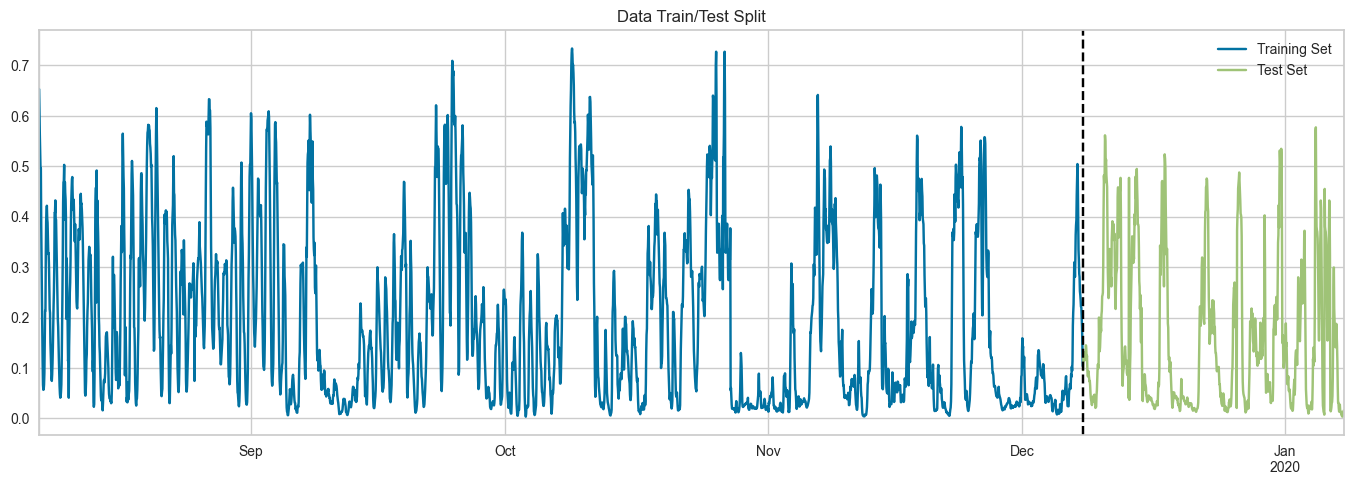

In [62]:
# 80/20 split
split_point = int(len(df) * 0.8)
cutoff_date_str = df.index[split_point]
print(f"cutoff date: {cutoff_date_str}")
train = df.loc[df.index < cutoff_date_str]
test = df.loc[df.index >= cutoff_date_str]

fig, ax = plt.subplots(figsize=(15, 5))
train[response_var].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test[response_var].plot(ax=ax, label='Test Set')
ax.axvline(cutoff_date_str, color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [63]:
y = df[response_var]
y.head()

2019-08-07 00:00:00    0.652524
2019-08-07 01:00:00    0.605852
2019-08-07 02:00:00    0.564094
2019-08-07 03:00:00    0.532721
2019-08-07 04:00:00    0.495608
Freq: H, Name: CF, dtype: float64

In [64]:
X = df.drop(columns=[response_var], axis=1)
X.head()

prediction_wind_decision_tree  hour  dayofweek  quarter  \
2019-08-07 00:00:00                       0.652568   0.0        2.0      3.0   
2019-08-07 01:00:00                       0.594954   1.0        2.0      3.0   
2019-08-07 02:00:00                       0.563370   2.0        2.0      3.0   
2019-08-07 03:00:00                       0.543258   3.0        2.0      3.0   
2019-08-07 04:00:00                       0.496438   4.0        2.0      3.0   

                     month    year  dayofyear  dayofmonth  weekofyear  \
2019-08-07 00:00:00    8.0  2019.0      219.0         7.0        32.0   
2019-08-07 01:00:00    8.0  2019.0      219.0         7.0        32.0   
2019-08-07 02:00:00    8.0  2019.0      219.0         7.0        32.0   
2019-08-07 03:00:00    8.0  2019.0      219.0         7.0        32.0   
2019-08-07 04:00:00    8.0  2019.0      219.0         7.0        32.0   

                     holiday_name_Christmas Day  holiday_name_Columbus Day  \
2019-08-07 00:00:00                           0                          0   
2019-08-07 01:00:00                           0                          0   
2019-08-07 02:00:00                           0                          0   
2019-08-07 03:00:00                           0                          0   
2019-08-07 04:00:00                           0                          0   

                     holiday_name_Labor Day  holiday_name_New Year's Day  \
2019-08-07 00:00:00                       0                            0   
2019-08-07 01:00:00                       0                            0   
2019-08-07 02:00:00                       0                            0   
2019-08-07 03:00:00                       0                            0   
2019-08-07 04:00:00                       0                            0   

                     holiday_name_Thanksgiving  holiday_name_Veterans Day  
2019-08-07 00:00:00                          0                          0  
2019-08-07 01:00:00                          0                          0  
2019-08-07 02:00:00                          0                          0  
2019-08-07 03:00:00                          0                          0  
2019-08-07 04:00:00                          0                          0

## Model Training and Testing

Will start out with a baseline model of AutoARIMA.

In [65]:
print(y.dtypes)
y.head()

float64


2019-08-07 00:00:00    0.652524
2019-08-07 01:00:00    0.605852
2019-08-07 02:00:00    0.564094
2019-08-07 03:00:00    0.532721
2019-08-07 04:00:00    0.495608
Freq: H, Name: CF, dtype: float64

In [66]:
print(X.dtypes)
X.head()


prediction_wind_decision_tree    float64
hour                             float64
dayofweek                        float64
quarter                          float64
month                            float64
year                             float64
dayofyear                        float64
dayofmonth                       float64
weekofyear                       float64
holiday_name_Christmas Day         int64
holiday_name_Columbus Day          int64
holiday_name_Labor Day             int64
holiday_name_New Year's Day        int64
holiday_name_Thanksgiving          int64
holiday_name_Veterans Day          int64
dtype: object


prediction_wind_decision_tree  hour  dayofweek  quarter  \
2019-08-07 00:00:00                       0.652568   0.0        2.0      3.0   
2019-08-07 01:00:00                       0.594954   1.0        2.0      3.0   
2019-08-07 02:00:00                       0.563370   2.0        2.0      3.0   
2019-08-07 03:00:00                       0.543258   3.0        2.0      3.0   
2019-08-07 04:00:00                       0.496438   4.0        2.0      3.0   

                     month    year  dayofyear  dayofmonth  weekofyear  \
2019-08-07 00:00:00    8.0  2019.0      219.0         7.0        32.0   
2019-08-07 01:00:00    8.0  2019.0      219.0         7.0        32.0   
2019-08-07 02:00:00    8.0  2019.0      219.0         7.0        32.0   
2019-08-07 03:00:00    8.0  2019.0      219.0         7.0        32.0   
2019-08-07 04:00:00    8.0  2019.0      219.0         7.0        32.0   

                     holiday_name_Christmas Day  holiday_name_Columbus Day  \
2019-08-07 00:00:00                           0                          0   
2019-08-07 01:00:00                           0                          0   
2019-08-07 02:00:00                           0                          0   
2019-08-07 03:00:00                           0                          0   
2019-08-07 04:00:00                           0                          0   

                     holiday_name_Labor Day  holiday_name_New Year's Day  \
2019-08-07 00:00:00                       0                            0   
2019-08-07 01:00:00                       0                            0   
2019-08-07 02:00:00                       0                            0   
2019-08-07 03:00:00                       0                            0   
2019-08-07 04:00:00                       0                            0   

                     holiday_name_Thanksgiving  holiday_name_Veterans Day  
2019-08-07 00:00:00                          0                          0  
2019-08-07 01:00:00                          0                          0  
2019-08-07 02:00:00                          0                          0  
2019-08-07 03:00:00                          0                          0  
2019-08-07 04:00:00                          0                          0

In [67]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.split import temporal_train_test_split

y_train, y_test, X_train, X_test = temporal_train_test_split(y, X)

fh = ForecastingHorizon(y_test.index, is_relative=False)
fh

ForecastingHorizon(['2019-11-30 12:00:00', '2019-11-30 13:00:00',
               '2019-11-30 14:00:00', '2019-11-30 15:00:00',
               '2019-11-30 16:00:00', '2019-11-30 17:00:00',
               '2019-11-30 18:00:00', '2019-11-30 19:00:00',
               '2019-11-30 20:00:00', '2019-11-30 21:00:00',
               ...
               '2020-01-07 14:00:00', '2020-01-07 15:00:00',
               '2020-01-07 16:00:00', '2020-01-07 17:00:00',
               '2020-01-07 18:00:00', '2020-01-07 19:00:00',
               '2020-01-07 20:00:00', '2020-01-07 21:00:00',
               '2020-01-07 22:00:00', '2020-01-07 23:00:00'],
              dtype='datetime64[ns]', length=924, freq='H', is_relative=False)

In [68]:
from sktime.forecasting.arima import AutoARIMA
forecaster = AutoARIMA()
forecaster.fit(y_train, X_train)
y_pred = forecaster.predict(fh, X=X_test)

MAE (Test Set): 0.012464620118024326


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='CF'>)

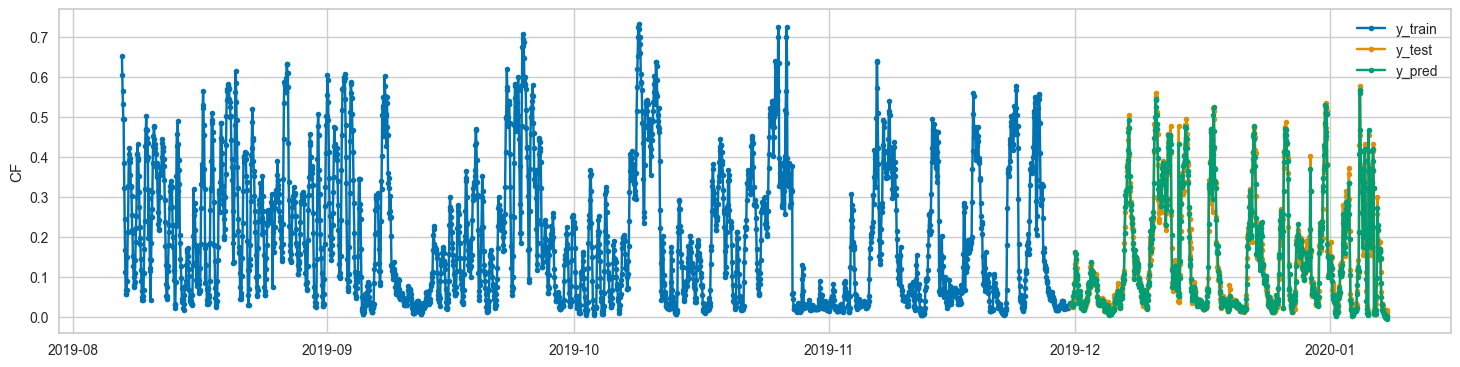

In [69]:
mae = mean_absolute_error(y_test, y_pred)
print("MAE (Test Set):", mae)

plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])

This model performs pretty well. Let's see if we can improve by cross validating with other models and optimizing hyperparameters of said models.

(Parameter estimation)

In [70]:
from sktime.registry import all_estimators
estimators = all_estimators(estimator_types="forecaster", return_names=False)

# Filter forecasters that support exogenous data
compatible_forecasters = [est for est in estimators if est.get_class_tag("scitype:y") == "both"]
print("Compatible Forecasters:", [est.__name__ for est in compatible_forecasters])


In [71]:
from sktime.registry import all_estimators
all_estimators(
    estimator_types="forecaster",
    filter_tags={
        'scitype:y': 'univariate',# target variable: 1 time series
        },
    as_dataframe=True
)

name  \
0                                        ARCH   
1                                        ARDL   
2                                       ARIMA   
3                                   AutoARIMA   
4                                     AutoETS   
5                      AutoEnsembleForecaster   
6                                     AutoREG   
7                                        BATS   
8                              CINNForecaster   
9                          ConformalIntervals   
10                                    Croston   
11                         CurveFitForecaster   
12          DirRecTabularRegressionForecaster   
13       DirRecTimeSeriesRegressionForecaster   
14                  DirectReductionForecaster   
15          DirectTabularRegressionForecaster   
16       DirectTimeSeriesRegressionForecaster   
17                                 DontUpdate   
18                       ExponentialSmoothing   
19                        HCrystalBallAdapter   
20                   HFTransformersForecaster   
21                                    IgnoreX   
22     MultioutputTabularRegressionForecaster   
23  MultioutputTimeSeriesRegressionForecaster   
24                            NaiveForecaster   
25                              NaiveVariance   
26                         NeuralForecastLSTM   
27                          NeuralForecastRNN   
28                   OnlineEnsembleForecaster   
29                  PolynomialTrendForecaster   
30                                    Prophet   
31      ProphetPiecewiseLinearTrendForecaster   
32                            PyKANForecaster   
33                       ReconcilerForecaster   
34       RecursiveTabularRegressionForecaster   
35    RecursiveTimeSeriesRegressionForecaster   
36                                    SARIMAX   
37                              STLForecaster   
38                          SquaringResiduals   
39                         StackingForecaster   
40                          StatsForecastARCH   
41                     StatsForecastAutoARIMA   
42                       StatsForecastAutoCES   
43                       StatsForecastAutoETS   
44                     StatsForecastAutoTBATS   
45                     StatsForecastAutoTheta   
46                         StatsForecastGARCH   
47                          StatsForecastMSTL   
48                           StatsModelsARIMA   
49                                      TBATS   
50                            ThetaForecaster   
51                     ThetaModularForecaster   
52                            TrendForecaster   
53                       UnobservedComponents   
54                                UpdateEvery   
55                          UpdateRefitsEvery   
56                                     YfromX   

                                               object  
0       <class 'sktime.forecasting.arch._uarch.ARCH'>  
1              <class 'sktime.forecasting.ardl.ARDL'>  
2   <class 'sktime.forecasting.arima._pmdarima.ARI...  
3   <class 'sktime.forecasting.arima._pmdarima.Aut...  
4            <class 'sktime.forecasting.ets.AutoETS'>  
5   <class 'sktime.forecasting.compose._ensemble.A...  
6       <class 'sktime.forecasting.auto_reg.AutoREG'>  
7              <class 'sktime.forecasting.bats.BATS'>  
8   <class 'sktime.forecasting.conditional_inverti...  
9   <class 'sktime.forecasting.conformal.Conformal...  
10       <class 'sktime.forecasting.croston.Croston'>  
11  <class 'sktime.forecasting.trend._curve_fit_fo...  
12  <class 'sktime.forecasting.compose._reduce.Dir...  
13  <class 'sktime.forecasting.compose._reduce.Dir...  
14  <class 'sktime.forecasting.compose._reduce.Dir...  
15  <class 'sktime.forecasting.compose._reduce.Dir...  
16  <class 'sktime.forecasting.compose._reduce.Dir...  
17  <class 'sktime.forecasting.stream._update.Dont...  
18  <class 'sktime.forecasting.exp_smoothing.Expon...  
19  <class 'sktime.forecasting.adapters._hcrystalb...  
20  <class 'sktime.for

In [72]:
from sktime.forecasting.arch import ARCH
from sktime.forecasting.ardl import ARDL
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.compose import AutoEnsembleForecaster
from sktime.forecasting.auto_reg import AutoREG
from sktime.forecasting.conditional_invertible_neural_network import CINNForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.fbprophet import Prophet

In [73]:
from sktime.forecasting.var import VAR
from sktime.forecasting.bats import BATS

Building upon the train-test split section above, this is a visualization of the folds in the Time series cross validation. 

In [74]:
### Temporal cross-validation

# This is splitting the time series iteratively.
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.utils import plot_windows

obs = 24*7 # next week of data
fh = ForecastingHorizon(np.arange(obs) + 1)
fh

ForecastingHorizon([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       159, 160, 161, 162, 163, 164, 165, 166, 167, 168],
      dtype='int32', length=168, is_relative=True)

(<Figure size 1600x480 with 1 Axes>,
 <Axes: xlabel='Time', ylabel='Window number'>)

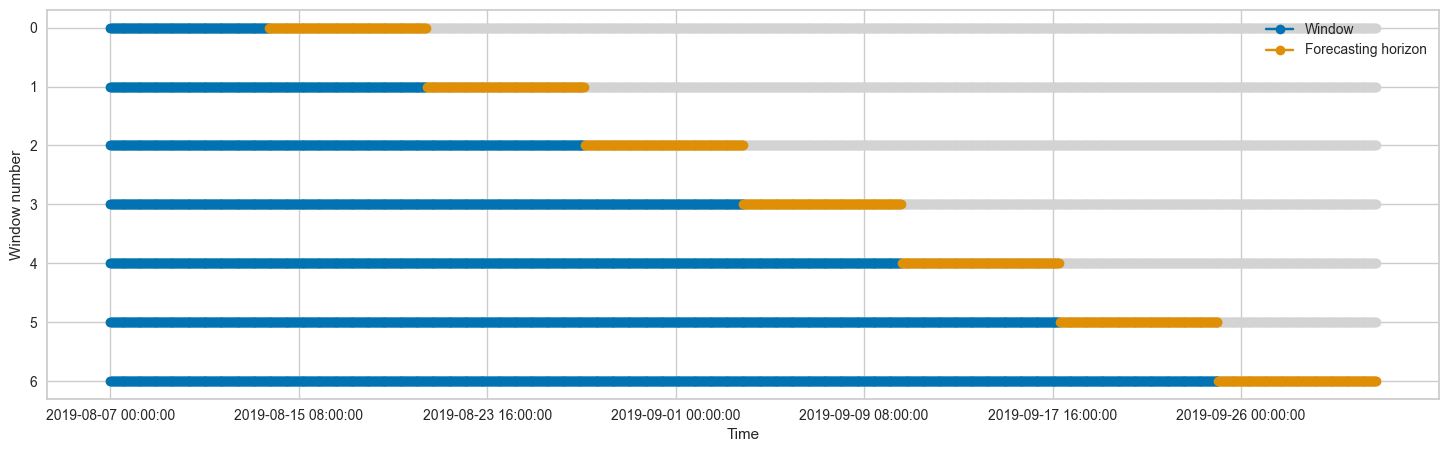

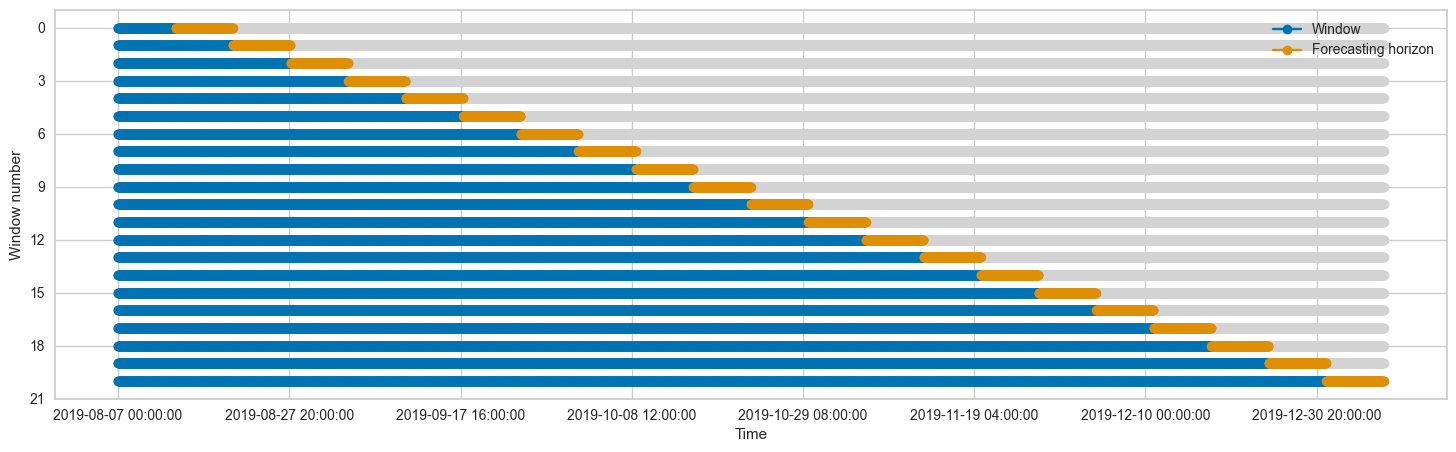

In [75]:
cv = ExpandingWindowSplitter(
    step_length=int(obs),
    fh=fh,
    initial_window=obs
)

plot_windows(cv, y.iloc[:obs*2*2*2])
plot_windows(cv, y)

In [76]:
from sktime.forecasting.compose import MultiplexForecaster
from sktime.forecasting.model_selection import (ForecastingGridSearchCV,
                                                SlidingWindowSplitter)

from sktime.forecasting.neuralforecast import NeuralForecastRNN
from sktime.forecasting.neuralforecast import NeuralForecastLSTM
# from sktime.regression.deep_learning.cnn import CNNRegressor
# from sktime.regression.deep_learning.rnn import SimpleRNNRegressor

forecaster = MultiplexForecaster(
    forecasters=[
        # ("arch", ARCH()),
        # ("ardl", ARDL()),
        ("arima", ARIMA()),
        ("autoarima", AutoARIMA()),
        # ("autoets", AutoETS()),
        # ("AutoEnsembleForecaster", AutoEnsembleForecaster()),
        # ("AutoREG", AutoREG()),
        # ("CINNForecaster", CINNForecaster()),
        ("exp_smoothing", ExponentialSmoothing()),
        ("poly_trend", PolynomialTrendForecaster()),
        ("prophet", Prophet()),
        # ("var", VAR()),
        # ("bats", BATS(use_box_cox=False)),# use_trend=True,
        # ("rnn", NeuralForecastRNN()),
        # ("lstm", NeuralForecastLSTM()),
        
    ]
)

param_grid = {
    "selected_forecaster": ["arima", "autoarima",  "exp_smoothing", "poly_trend", "prophet",
                            # "var", "bats",
                            # "rnn", "lstm",
                            ],
    "arima__order": [(1, 1, 1), (2, 1, 0)],
    "autoarima__sp": [None, 7*24, 1*24], # hourly data: 30ish*24 is monthly, 7*24 is weekly, 1*24 is daily
    # "autoets__automatic": [True, False],
    "exp_smoothing__trend": ["add", "mul"],
    "poly_trend__degree": [1, 2, 3],
    # "prophet__yearly_seasonality": [True, False],
    "prophet__yearly_seasonality": [True, False],
    # "bats__use_trend": [True, False],
    
}

gscv = ForecastingGridSearchCV(forecaster=forecaster, cv=cv, param_grid=param_grid)
gscv


ForecastingGridSearchCV(cv=ExpandingWindowSplitter(fh=ForecastingHorizon([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       159, 160, 161, 162, 163, 164, 165, 166, 167, 168],
      dtype='int32', length=168, is_relative=True),
                                                   initial_window=168,
                                                   step_length=168),
                        forecaster=MultiplexForecaster(forecasters=[('arima',
                                                                     ARIMA()),
                                                                    ('autoarima',
                                                                     AutoARIMA()),
                                                                    ('exp_smoothing',
                                                                     ExponentialSmoothing()),
                                                                    ('poly_trend',
                                                                     PolynomialTrendForecaster()),
                                                                    ('prophet',
                                                                     Prophet())]),
                        param_grid={'arima__order': [(1, 1, 1), (2, 1, 0)],
                                    'autoarima__sp': [None, 168, 24],
                                    'exp_smoothing__trend': ['add', 'mul'],
                                    'poly_trend__degree': [1, 2, 3],
                                    'prophet__yearly_seasonality': [True,
                                                                    False],
                                    'selected_forecaster': ['arima',
                                                            'autoarima',
                                                            'exp_smoothing',
                                                            'poly_trend',
                                                            'prophet']})

In [77]:
gscv.fit(y=y_train, X=X_train)

ForecastingGridSearchCV(cv=ExpandingWindowSplitter(fh=ForecastingHorizon([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       159, 160, 161, 162, 163, 164, 165, 166, 167, 168],
      dtype='int32', length=168, is_relative=True),
                                                   initial_window=168,
                                                   step_length=168),
                        forecaster=MultiplexForecaster(forecasters=[('arima',
                                                                     ARIMA()),
                                                                    ('autoarima',
                                                                     AutoARIMA()),
                                                                    ('exp_smoothing',
                                                                     ExponentialSmoothing()),
                                                                    ('poly_trend',
                                                                     PolynomialTrendForecaster()),
                                                                    ('prophet',
                                                                     Prophet())]),
                        param_grid={'arima__order': [(1, 1, 1), (2, 1, 0)],
                                    'autoarima__sp': [None, 168, 24],
                                    'exp_smoothing__trend': ['add', 'mul'],
                                    'poly_trend__degree': [1, 2, 3],
                                    'prophet__yearly_seasonality': [True,
                                                                    False],
                                    'selected_forecaster': ['arima',
                                                            'autoarima',
                                                            'exp_smoothing',
                                                            'poly_trend',
                                                            'prophet']})

In [78]:
print(gscv.best_params_)
gscv.best_params_

{'arima__order': (1, 1, 1),
 'autoarima__sp': 168,
 'exp_smoothing__trend': 'add',
 'poly_trend__degree': 1,
 'prophet__yearly_seasonality': True,
 'selected_forecaster': 'autoarima'}

In [79]:
print(gscv.best_score_)
gscv.best_score_

0.15553589086462402

In [80]:
gscv

ForecastingGridSearchCV(cv=ExpandingWindowSplitter(fh=ForecastingHorizon([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       159, 160, 161, 162, 163, 164, 165, 166, 167, 168],
      dtype='int32', length=168, is_relative=True),
                                                   initial_window=168,
                                                   step_length=168),
                        forecaster=MultiplexForecaster(forecasters=[('arima',
                                                                     ARIMA()),
                                                                    ('autoarima',
                                                                     AutoARIMA()),
                                                                    ('exp_smoothing',
                                                                     ExponentialSmoothing()),
                                                                    ('poly_trend',
                                                                     PolynomialTrendForecaster()),
                                                                    ('prophet',
                                                                     Prophet())]),
                        param_grid={'arima__order': [(1, 1, 1), (2, 1, 0)],
                                    'autoarima__sp': [None, 168, 24],
                                    'exp_smoothing__trend': ['add', 'mul'],
                                    'poly_trend__degree': [1, 2, 3],
                                    'prophet__yearly_seasonality': [True,
                                                                    False],
                                    'selected_forecaster': ['arima',
                                                            'autoarima',
                                                            'exp_smoothing',
                                                            'poly_trend',
                                                            'prophet']})

In [81]:
# make sure we are predicting on a fh for the whole X_test set
# otherwise - this error: ValueError: X array dims (n_rows) != n_periods. Received n_rows=169 and n_periods=168
# n_rows is size of X_test, n_periods is size of fh
fh = ForecastingHorizon(np.arange(len(X_test)) + 1)
fh

ForecastingHorizon([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       915, 916, 917, 918, 919, 920, 921, 922, 923, 924],
      dtype='int32', length=924, is_relative=True)

In [82]:
assert len(fh) == len(X_test)

In [83]:
y_pred = gscv.predict(fh, X=X_test) # this tries out all of the parameter combinations, generates predictions, evaluates them, and picks the best one/set


In [84]:
print(gscv.get_fitted_params()) # result of Parameter estimation

In [85]:
mae = mean_absolute_error(y_test, y_pred)
print("MAE (Test Set):", mae)


It appears that the AutoARIMA model performed the best.

I will also mention that the MAE on the test set increased using this time series cross validation method, compared to when the original train/test split with a cutoff date was used. (This makes sense, as the cross validation method will be less likely to overfit)

## Output: MAE (Test Set)

Using the optimized AutoARIMA model and the inital train/test split, let's see the MAE:

In [86]:
print("MAE (Test Set):", mae)
mae

0.012464620118024326

## Plot: Predictions vs. Actuals (Test Set)

For this visualization, I will use the train/test split.



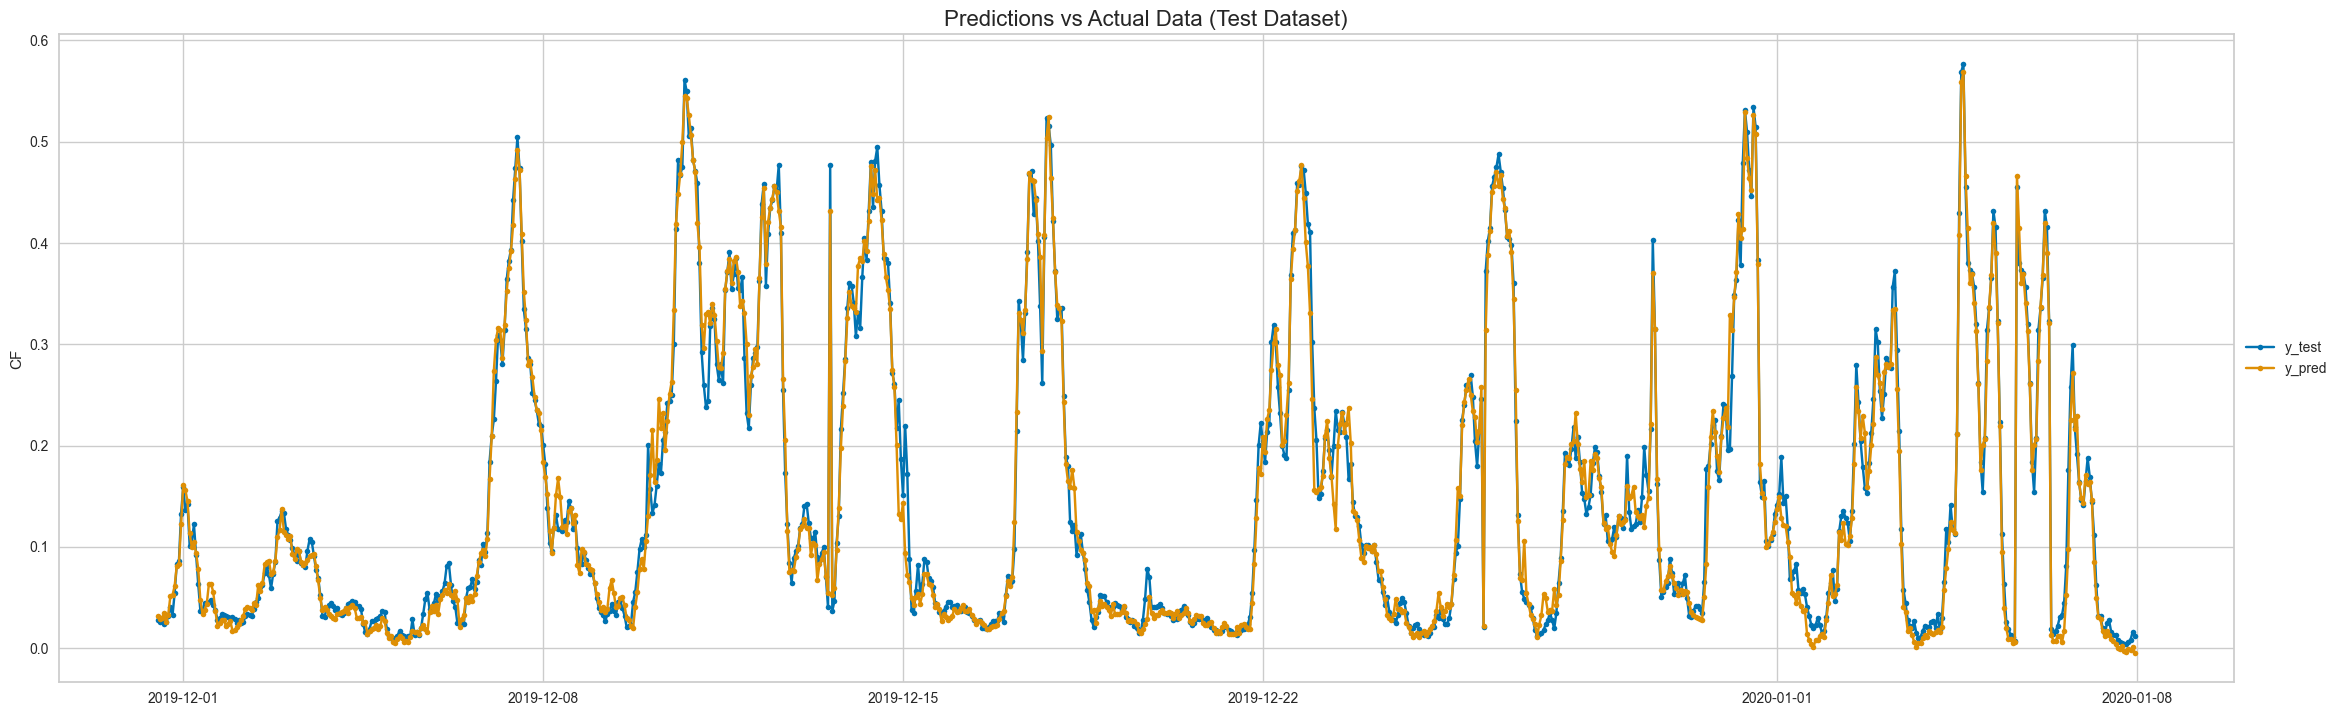

In [87]:
fig, ax = plot_series(
    # y_train,
    y_test,
    y_pred,
    labels=[
        # 'y_train',
        'y_test',
        'y_pred',
    ]
    )

fig.set_size_inches(25, 8)  # Change the figure size to 25 inches wide by 8 inches tall

ax.set_title('Predictions vs Actual Data (Test Dataset)', fontsize=16)  # Set the title and font size
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));  # Adjust the legend position
plt.show()

To visualize the model performance during cross-validation, I will also look at each iteration of the time series cross validation, and compare that to the actual values.
- This is done via prediction data using `ExpandingWindowSplitter()` and `evaluate()` with an AutoARIMA and forecasting window sizes of 7*24=168. (1 week)

In [88]:
obs = 24*7 # next week of data
fh = ForecastingHorizon(np.arange(obs) + 1)
fh

ForecastingHorizon([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       159, 160, 161, 162, 163, 164, 165, 166, 167, 168],
      dtype='int32', length=168, is_relative=True)

In [89]:
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, fh=fh)

print(y_train.size)
print(y_test.size)

print(X_train.size)
print(X_test.size)

In [90]:
gscv.get_fitted_params()

{'forecaster': AutoARIMA(sp=168),
 'prediction_wind_decision_tree': 1.0168926901563822,
 'hour': -0.0001707013698324052,
 'dayofweek': -0.0003476625501971101,
 'quarter': 0.004848226736897863,
 'month': 0.0001507645621049226,
 'year': -6.888781304003769e-06,
 'dayofyear': -3.430128740969552e-05,
 'dayofmonth': 0.0001401122994541285,
 'weekofyear': 4.476255346588035e-05,
 'holiday_name_Christmas Day': -2.385905265556783e-18,
 'holiday_name_Columbus Day': -0.003986979704274552,
 'holiday_name_Labor Day': 0.011196466528867107,
 "holiday_name_New Year's Day": 0.0,
 'holiday_name_Thanksgiving': 0.0024949028089759234,
 'holiday_name_Veterans Day': 0.005213684454900997,
 'sigma2': 1.4866660863295151,
 'order': (0, 0, 0),
 'seasonal_order': (0, 0, 0, 168),
 'aic': 6226.793266107303,
 'aicc': 6226.990725272457,
 'bic': 6321.6304558722595,
 'hqic': 6261.043364393293,
 'forecaster__prediction_wind_decision_tree': 1.0168926901563822,
 'forecaster__hour': -0.0001707013698324052,
 'forecaster__dayof

In [91]:
gscv.best_params_

{'arima__order': (1, 1, 1),
 'autoarima__sp': 168,
 'exp_smoothing__trend': 'add',
 'poly_trend__degree': 1,
 'prophet__yearly_seasonality': True,
 'selected_forecaster': 'autoarima'}

In [92]:
from sktime.forecasting.model_evaluation import evaluate

forecaster = AutoARIMA()

In [93]:
best_params = gscv.best_params_

sp_value = best_params.get('autoarima__sp', None)
if sp_value:
    forecaster.set_params(sp=sp_value)

In [94]:
forecaster

AutoARIMA(sp=168)

In [95]:
# how to split the model 
# (cv strategy: starts with initial_window, expands by step_length w/ each step until it encompasses all data)
# (excluding test set, which is defined by fh/forecasting horizon)
cv = ExpandingWindowSplitter(
    step_length=obs,
    fh=fh,
    initial_window=obs*2 # increasing initial window to 2 weeks, remove error where 1st model predictions were NA
    # this error occured because the optimal sp/period for seasonal differencing is 168, so needed more data
)

results = evaluate(
    forecaster=forecaster, y=y, X=X, cv=cv, strategy="refit", return_data=True 
)


In [96]:
results.head()

test_MeanAbsolutePercentageError  fit_time  pred_time  len_train_window  \
0                          0.096347  0.340307   0.028390               336   
1                          0.104948  0.480796   0.030415               504   
2                          0.287616  0.763614   0.028858               672   
3                          0.255734  0.658761   0.029445               840   
4                          0.106551  0.684681   0.026118              1008   

               cutoff                                            y_train  \
0 2019-08-20 23:00:00  2019-08-07 00:00:00    0.652524
2019-08-07 01:...   
1 2019-08-27 23:00:00  2019-08-07 00:00:00    0.652524
2019-08-07 01:...   
2 2019-09-03 23:00:00  2019-08-07 00:00:00    0.652524
2019-08-07 01:...   
3 2019-09-10 23:00:00  2019-08-07 00:00:00    0.652524
2019-08-07 01:...   
4 2019-09-17 23:00:00  2019-08-07 00:00:00    0.652524
2019-08-07 01:...   

                                              y_test  \
0  2019-08-21 00:00:00    0.434057
2019-08-21 01:...   
1  2019-08-28 00:00:00    0.308110
2019-08-28 01:...   
2  2019-09-04 00:00:00    0.507541
2019-09-04 01:...   
3  2019-09-11 00:00:00    0.069512
2019-09-11 01:...   
4  2019-09-18 00:00:00    0.235803
2019-09-18 01:...   

                                              y_pred  
0  2019-08-21 00:00:00    0.456987
2019-08-21 01:...  
1  2019-08-28 00:00:00    0.310961
2019-08-28 01:...  
2  2019-09-04 00:00:00    0.505303
2019-09-04 01:...  
3  2019-09-11 00:00:00    0.078592
2019-09-11 01:...  
4  2019-09-18 00:00:00    0.253338
2019-09-18 01:...

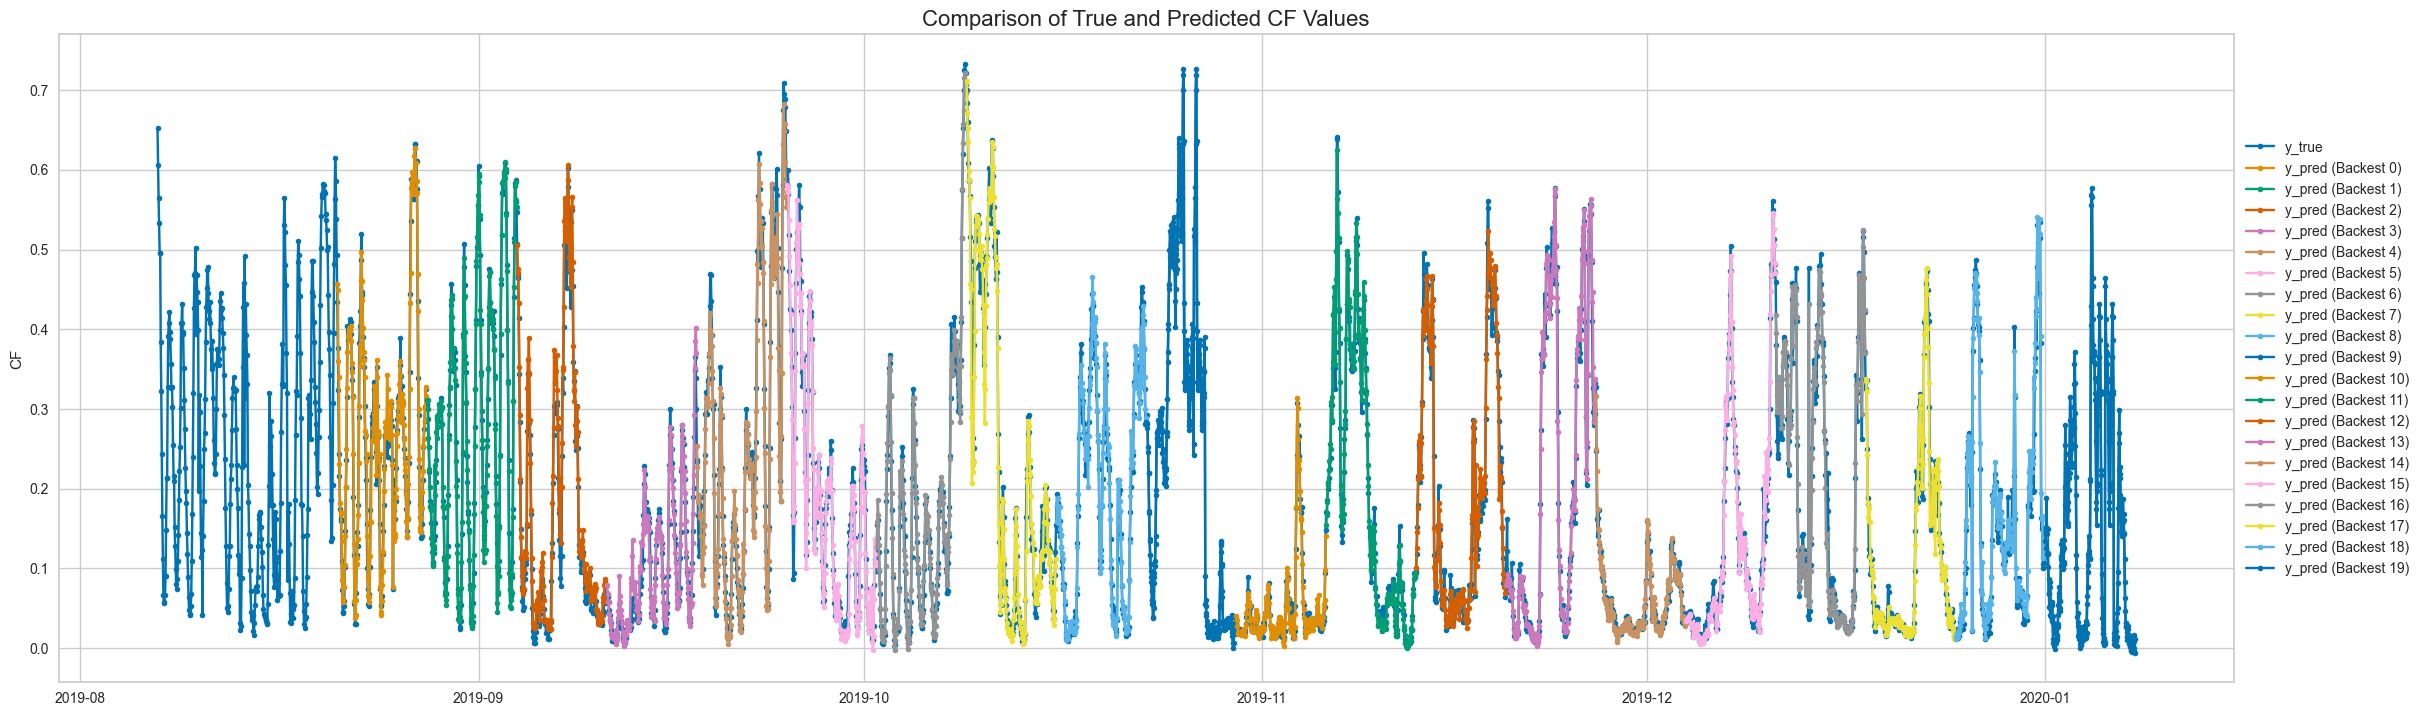

In [97]:
fig, ax = plot_series(
    y,
    results['y_pred'].iloc[0],
    results['y_pred'].iloc[1],
    results['y_pred'].iloc[2],
    results['y_pred'].iloc[3],
    results['y_pred'].iloc[4],
    results['y_pred'].iloc[5],
    results['y_pred'].iloc[6],
    results['y_pred'].iloc[7],
    results['y_pred'].iloc[8],
    results['y_pred'].iloc[9],
    results['y_pred'].iloc[10],
    results['y_pred'].iloc[11],
    results['y_pred'].iloc[12],
    results['y_pred'].iloc[13],
    results['y_pred'].iloc[14],
    results['y_pred'].iloc[15],
    results['y_pred'].iloc[16],
    results['y_pred'].iloc[17],
    results['y_pred'].iloc[18],
    results['y_pred'].iloc[19],
    # results['y_pred'].iloc[20],
    
    
    labels=["y_true"] + ["y_pred (Backest " + str(x) + ")" for x in range(0, (20))]# ["y_pred (Backest " + str(x) + ")" for x in range(1 + 5)]
    
)
fig.set_size_inches(25, 8)  # Change the figure size to 15 inches wide by 8 inches tall

ax.set_title('Comparison of True and Predicted CF Values', fontsize=16)  # Set the title and font size
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));  # Adjust the legend position
plt.show()  # Display the plot

The average error is solid, and the prediction overall tend to be right on top of the actuals!

What happened here:
- Started with a window of 2 weeks (24 hours in a day * 7 days per week) of observations [Blue lines at start]
- Trained an algorithm and made predictions on the next 1 week [Orange line at start]
- Compared that to the actual data
- Moved 1 week ahead
- Updated algorithm with the new window size of 3 weeks
- Re-trained algorithm, made predictions on the next 1 week
- Updated algorithm with the new window size of 4 weeks
- Re-trained algorithm, made predictions on the next 1 week
- Process continues! (Until we reach the end of the time series ie. have no data to compare our prediction to)

## Making Predictions (on 'Predict' Sheet from input Excel file)

Now that we are making prediction on new/unseen data that we cannot compare the results with (since it is in the future), I will re-train the model using ALL data I have available to me, and then make the predictions!

In [98]:
df_test = test_data.copy()
print(df_test.shape)
df_test = ensure_hourly_frequency(df=df_test)

df_test.head()


CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
2020-01-09 00:00:00 NaN        1.69        1.88        3.15        0.92   
2020-01-09 01:00:00 NaN        1.60        2.02        3.91        0.44   
2020-01-09 02:00:00 NaN        1.79        2.14        4.20        0.65   
2020-01-09 03:00:00 NaN        2.01        2.32        5.17        0.51   
2020-01-09 04:00:00 NaN        2.12        2.54        4.19        0.77   

                     WS_1193865  WS_1321569  WS_1324653  WS_1358699  \
2020-01-09 00:00:00        2.27        1.14        1.24        2.98   
2020-01-09 01:00:00        2.36        1.15        1.63        2.83   
2020-01-09 02:00:00        2.06        1.28        2.36        3.07   
2020-01-09 03:00:00        2.31        0.83        3.39        3.38   
2020-01-09 04:00:00        4.52        0.97        2.89        3.79   

                     WS_1366338  ...  WS_78208  WS_811655  WS_839753  \
2020-01-09 00:00:00        2.53  ...      1.40       1.27       1.27   
2020-01-09 01:00:00        2.84  ...      1.02       1.11       1.43   
2020-01-09 02:00:00        2.34  ...      1.39       1.42       1.42   
2020-01-09 03:00:00        2.53  ...      1.55       2.01       1.26   
2020-01-09 04:00:00        4.21  ...      1.64       2.40       1.69   

                     WS_875373  WS_883683  WS_883699  WS_914573  WS_918665  \
2020-01-09 00:00:00       1.43       1.28       1.91       1.12       1.15   
2020-01-09 01:00:00       2.04       1.60       1.57       1.03       1.28   
2020-01-09 02:00:00       2.91       1.81       1.85       1.10       1.56   
2020-01-09 03:00:00       2.49       2.09       2.09       1.06       2.12   
2020-01-09 04:00:00       1.36       2.08       2.06       1.08       2.33   

                     WS_920775  WS_921049  
2020-01-09 00:00:00       1.35       1.46  
2020-01-09 01:00:00       1.49       1.29  
2020-01-09 02:00:00       1.54       1.56  
2020-01-09 03:00:00       1.66       2.18  
2020-01-09 04:00:00       2.17       2.60  

[5 rows x 113 columns]

In [99]:
# Get predictions from decision tree with wind 
X_predict_wind = df_test.drop(response_var, axis=1)
print(X_predict_wind.shape)
X_predict_wind.index.freq = 'H'
print(X_predict_wind.index.dtype)

In [100]:
model = load_model(os.path.join(INTER_DIR, "optimal_model"))
model

Pipeline(memory=FastMemory(location=C:\Users\Myles\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['WS_1133733', 'WS_1156770',
                                             'WS_1156968', 'WS_1182195',
                                             'WS_1193865', 'WS_1321569',
                                             'WS_1324653', 'WS_1358699',
                                             'WS_1366338', 'WS_1366351',
                                             'WS_1369320', 'WS_1461024',
                                             'WS_1481513', 'WS_1504146',
                                             'WS_1513782', 'WS_1513805',
                                             'WS_1571...
                                             'WS_1628663', 'WS_1681085',
                                             'WS_1820276', 'WS_1820279',
                                             'WS_1899876', 'WS_1911282',
                                             'WS_1937650', 'WS_1937653',
                                             'WS_1953863', 'WS_1960535', ...],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('trained_model',
                 <catboost.core.CatBoostRegressor object at 0x00000288C816FF50>)])

In [101]:
X_predict_CF = pd.DataFrame(
    {'prediction_wind_decision_tree': model.predict(X_predict_wind)},
    index=X_predict_wind.index
)
X_predict_CF.head()

prediction_wind_decision_tree
2020-01-09 00:00:00                      -0.003053
2020-01-09 01:00:00                       0.012505
2020-01-09 02:00:00                       0.025140
2020-01-09 03:00:00                       0.024220
2020-01-09 04:00:00                       0.013417

In [102]:
# Further pre-processing
X_predict_CF = create_features(X_predict_CF)
X_predict_CF = pd.get_dummies(X_predict_CF)
del X_predict_CF['is_holiday']

holidays_list = [
    'holiday_name_Christmas Day',
    'holiday_name_Columbus Day',
    'holiday_name_Labor Day',
    "holiday_name_New Year's Day",
    "holiday_name_Thanksgiving",
    "holiday_name_Veterans Day",
]
for holiday in holidays_list:
    if holiday not in set(X_predict_CF.columns):
        X_predict_CF[holiday] = 0

X_predict_CF = prepare_data_for_sktime(X_predict_CF)
print(X_predict_CF.dtypes)

print(len(set(X_predict_CF.columns)))
print(len(set(X.columns)))
assert set(X_predict_CF.columns) == set(X.columns)

Normally, we would be done preparing this dataset for predictions. But, given that there is a gap of 1 day between the training set and the predict set, I will have to fill this missing data. (We need data leading up to the prediction set so that the ARIMA model can make predictions)

Note: The reason why I initially was getting the following error is because I did not notice this 1 day gap between train dat and predict data:

"sktime: ValueError: X array dims (n_rows) != n_periods. Received n_rows=93 and n_periods=117"

In [103]:
# Join together train/predict
df_joined = pd.concat(
    objs=[df, X_predict_CF]
)

df_joined = ensure_hourly_frequency(df=df_joined)
del df_joined['CF']
cutoff_date_str = df_joined.tail(117).index[0]
print(f"cutoff_date_str: {cutoff_date_str}")
df_joined.tail(117)

prediction_wind_decision_tree  hour  dayofweek  quarter  \
2020-01-08 00:00:00                            NaN   NaN        NaN      NaN   
2020-01-08 01:00:00                            NaN   NaN        NaN      NaN   
2020-01-08 02:00:00                            NaN   NaN        NaN      NaN   
2020-01-08 03:00:00                            NaN   NaN        NaN      NaN   
2020-01-08 04:00:00                            NaN   NaN        NaN      NaN   
...                                            ...   ...        ...      ...   
2020-01-12 16:00:00                       0.045717  16.0        6.0      1.0   
2020-01-12 17:00:00                       0.028000  17.0        6.0      1.0   
2020-01-12 18:00:00                       0.028117  18.0        6.0      1.0   
2020-01-12 19:00:00                       0.034966  19.0        6.0      1.0   
2020-01-12 20:00:00                       0.031788  20.0        6.0      1.0   

                     month    year  dayofyear  dayofmonth  weekofyear  \
2020-01-08 00:00:00    NaN     NaN        NaN         NaN         NaN   
2020-01-08 01:00:00    NaN     NaN        NaN         NaN         NaN   
2020-01-08 02:00:00    NaN     NaN        NaN         NaN         NaN   
2020-01-08 03:00:00    NaN     NaN        NaN         NaN         NaN   
2020-01-08 04:00:00    NaN     NaN        NaN         NaN         NaN   
...                    ...     ...        ...         ...         ...   
2020-01-12 16:00:00    1.0  2020.0       12.0        12.0         2.0   
2020-01-12 17:00:00    1.0  2020.0       12.0        12.0         2.0   
2020-01-12 18:00:00    1.0  2020.0       12.0        12.0         2.0   
2020-01-12 19:00:00    1.0  2020.0       12.0        12.0         2.0   
2020-01-12 20:00:00    1.0  2020.0       12.0        12.0         2.0   

                     holiday_name_Christmas Day  holiday_name_Columbus Day  \
2020-01-08 00:00:00                         NaN                        NaN   
2020-01-08 01:00:00                         NaN                        NaN   
2020-01-08 02:00:00                         NaN                        NaN   
2020-01-08 03:00:00                         NaN                        NaN   
2020-01-08 04:00:00                         NaN                        NaN   
...                                         ...                        ...   
2020-01-12 16:00:00                         0.0                        0.0   
2020-01-12 17:00:00                         0.0                        0.0   
2020-01-12 18:00:00                         0.0                        0.0   
2020-01-12 19:00:00                         0.0                        0.0   
2020-01-12 20:00:00                         0.0                        0.0   

                     holiday_name_Labor Day  holiday_name_New Year's Day  \
2020-01-08 00:00:00                     NaN                          NaN   
2020-01-08 01:00:00                     NaN                          NaN   
2020-01-08 02:00:00                     NaN                          NaN   
2020-01-08 03:00:00                     NaN                          NaN   
2020-01-08 04:00:00                     NaN                          NaN   
...                                     ...                          ...   
2020-01-12 16:00:00                     0.0                          0.0   
2020-01-12 17:00:00                     0.0                          0.0   
2020-01-12 18:00:00                     0.0                          0.0   
2020-01-12 19:00:00                     0.0                          0.0   
2020-01-12 20:00:00                     0.0                          0.0   

                     holiday_name_Thanksgiving  holiday_name_Veterans Day  
2020-01-08 00:00:00                        NaN                        NaN  
2020-01-08 01:00:00                        NaN                        NaN  
2020-01-08 02:00:00                        NaN                        NaN  
2020-01-08 03:00:00          

Once again, we just introduced NA into our dataset. Because we do not have prediction data for wind model for these 24 hours of data, we are going to have to forward fill the values from the wind prediction model in the training dataset.

Because of the weekly trend, I will use a similar strategy as before, and simply take the values from last day at this same exact time.

In [104]:
print(df_joined.isna().sum())

In [105]:
df_joined = custom_ffill(df_joined, list(df_joined.columns), 24)

In [106]:
print(df_joined.isna().sum())

Now that the forward filling is done, we can drop the data from the training set.

In [107]:
req_cutoff_date_str = (df_joined.index >= cutoff_date_str)
df_joined = df_joined[req_cutoff_date_str]

assert df_joined.shape[0] == 117



The columns of data regarding the date (day of week, holidays, etc.) do not need to be forward filled. Let's make sure those are correct:

In [108]:
# Further pre-processing
df_joined = create_features(df_joined)
df_joined = pd.get_dummies(df_joined)
del df_joined['is_holiday']

holidays_list = [
    'holiday_name_Christmas Day',
    'holiday_name_Columbus Day',
    'holiday_name_Labor Day',
    "holiday_name_New Year's Day",
    "holiday_name_Thanksgiving",
    "holiday_name_Veterans Day",
]
for holiday in holidays_list:
    if holiday not in set(df_joined.columns):
        df_joined[holiday] = 0

df_joined = prepare_data_for_sktime(df_joined)
print(df_joined.dtypes)

print(len(set(df_joined.columns)))
print(len(set(X.columns)))
assert set(df_joined.columns) == set(X.columns)


In [109]:
df_joined.head()

prediction_wind_decision_tree  hour  dayofweek  quarter  \
2020-01-08 00:00:00                       0.176280     0          2        1   
2020-01-08 01:00:00                       0.168048     1          2        1   
2020-01-08 02:00:00                       0.170368     2          2        1   
2020-01-08 03:00:00                       0.153007     3          2        1   
2020-01-08 04:00:00                       0.093067     4          2        1   

                     month  year  dayofyear  dayofmonth  weekofyear  \
2020-01-08 00:00:00      1  2020          8           8         2.0   
2020-01-08 01:00:00      1  2020          8           8         2.0   
2020-01-08 02:00:00      1  2020          8           8         2.0   
2020-01-08 03:00:00      1  2020          8           8         2.0   
2020-01-08 04:00:00      1  2020          8           8         2.0   

                     holiday_name_Christmas Day  holiday_name_Columbus Day  \
2020-01-08 00:00:00                         0.0                        0.0   
2020-01-08 01:00:00                         0.0                        0.0   
2020-01-08 02:00:00                         0.0                        0.0   
2020-01-08 03:00:00                         0.0                        0.0   
2020-01-08 04:00:00                         0.0                        0.0   

                     holiday_name_Labor Day  holiday_name_New Year's Day  \
2020-01-08 00:00:00                     0.0                          0.0   
2020-01-08 01:00:00                     0.0                          0.0   
2020-01-08 02:00:00                     0.0                          0.0   
2020-01-08 03:00:00                     0.0                          0.0   
2020-01-08 04:00:00                     0.0                          0.0   

                     holiday_name_Thanksgiving  holiday_name_Veterans Day  
2020-01-08 00:00:00                        0.0                        0.0  
2020-01-08 01:00:00                        0.0                        0.0  
2020-01-08 02:00:00                        0.0                        0.0  
2020-01-08 03:00:00                        0.0                        0.0  
2020-01-08 04:00:00                        0.0                        0.0

Now that the data has been feature engineered like the training set, we can setup the forecasting horizon.

In [110]:
y_train = df[response_var]
y_test = None
X_train = df.drop(response_var, axis=1)
X_test = df_joined.copy()
print(X_test.index.min())

fh = ForecastingHorizon(X_test.index, is_relative=False)
print(fh.min())
print(len(fh))


In [111]:
assert X_test.index.min() == fh.min()

Important Note: There is a 1 day gap between train/predict data (train ends on 1/7/2020 at 23:00, predict starts at 1/9/2020 at 00:00), so need to ensure that we are using the indices from the predict dataframe, and not just the next 93 hourly data points.

In [112]:
print("Length of fh:", len(fh))
print("Length of X_test:", len(X_test))

In [113]:
time_diffs = X_test.index.to_series().diff().unique()
print(time_diffs)

In [114]:
forecaster = AutoARIMA()
forecaster.set_params(sp=sp_value)

AutoARIMA(sp=168)

In [116]:
# forecaster = AutoARIMA()
forecaster.fit(y_train, X_train)
y_pred = forecaster.predict(fh, X=X_test)

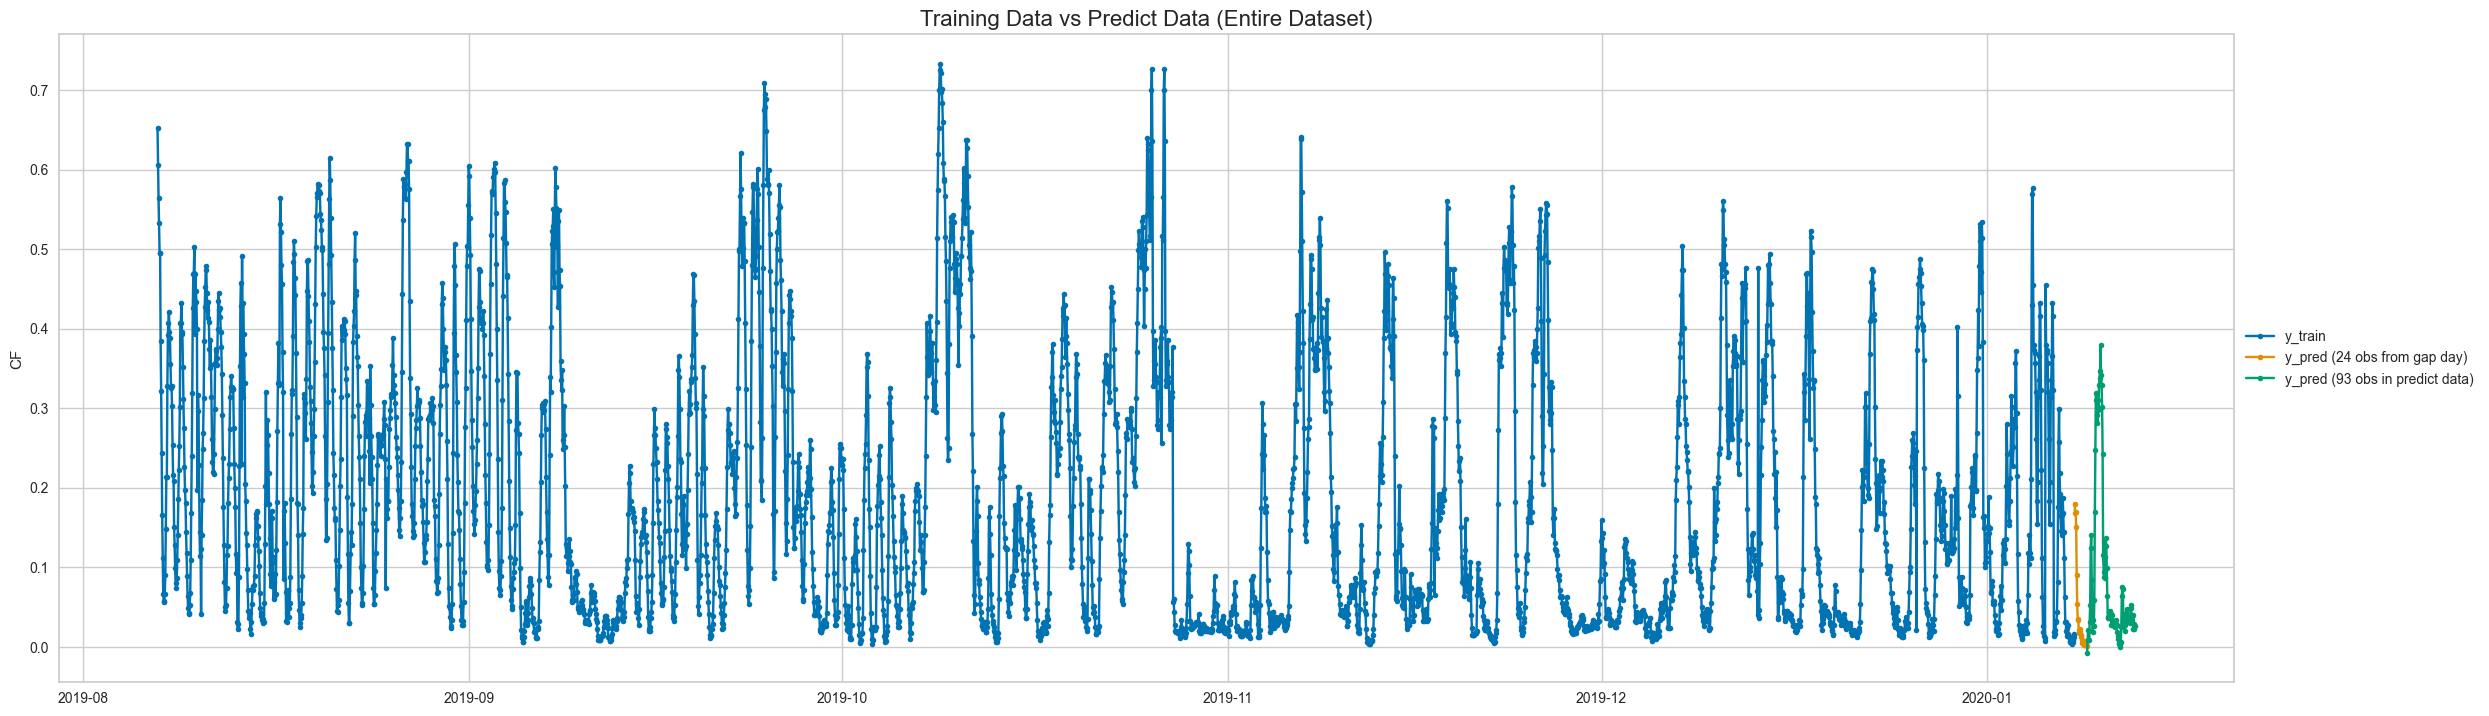

In [123]:
fig, ax = plot_series(
    y_train,
    y_pred.head(24),
    y_pred.tail(93),
    labels=[
        'y_train',
        'y_pred (24 obs from gap day)',
        'y_pred (93 obs in predict data)',
    ]
    )

fig.set_size_inches(25, 8)  # Change the figure size to 25 inches wide by 8 inches tall

ax.set_title('Training Data vs Predict Data (Entire Dataset)', fontsize=16)  # Set the title and font size
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));  # Adjust the legend position
plt.show()

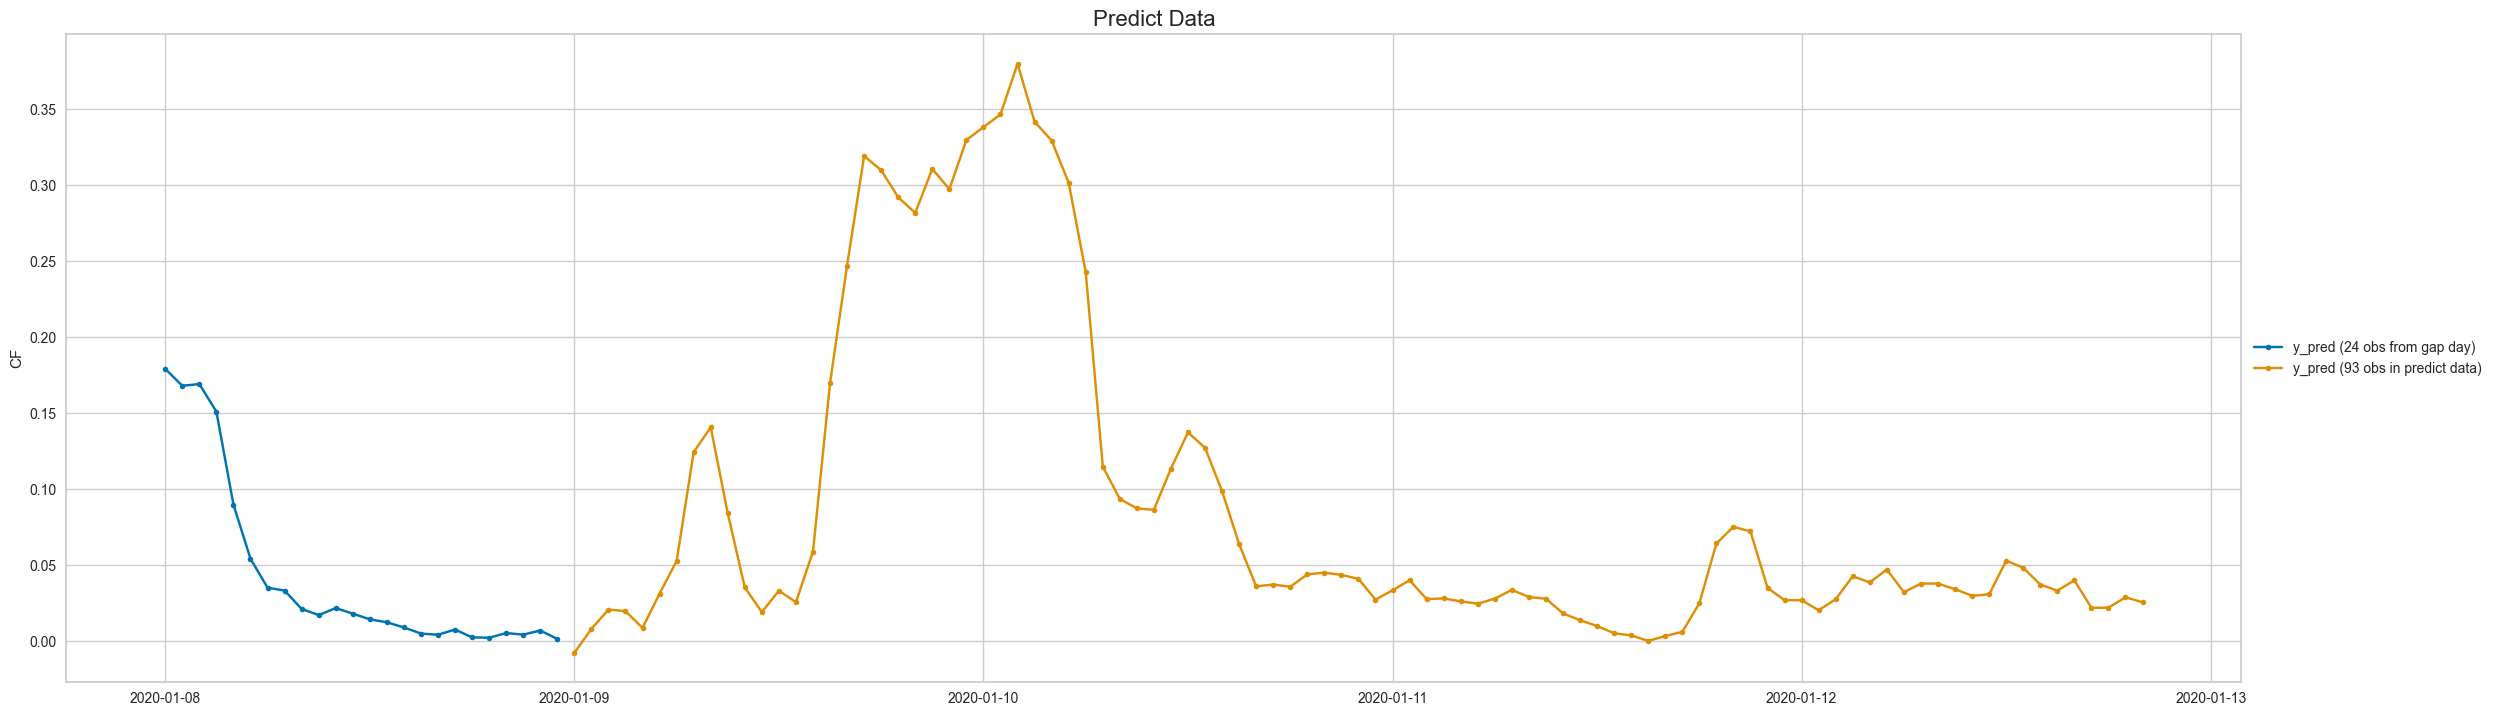

In [124]:
fig, ax = plot_series(
    y_pred.head(24),
    y_pred.tail(93),
    labels=[
        'y_pred (24 obs from gap day)',
        'y_pred (93 obs in predict data)',
    ]
    )

fig.set_size_inches(25, 8)

ax.set_title('Predict Data', fontsize=16)  # Set the title and font size
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));  # Adjust the legend position
plt.show()

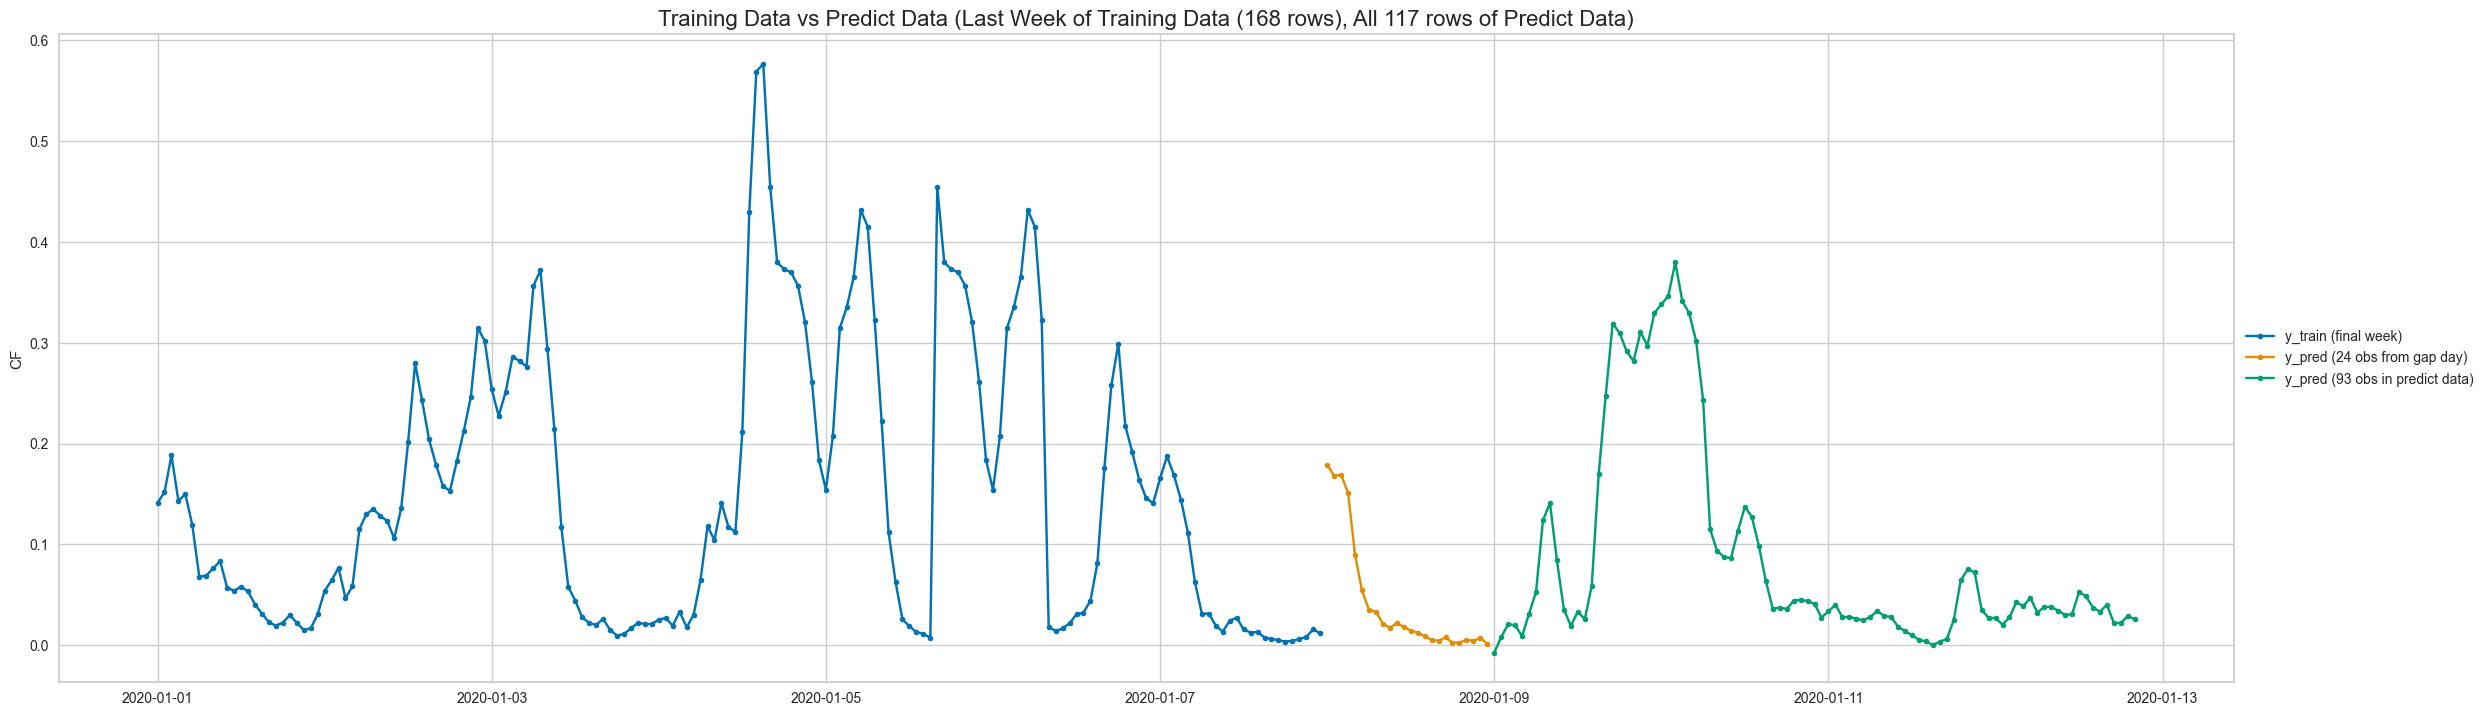

In [125]:
fig, ax = plot_series(
    y_train.tail(24*7),
    y_pred.head(24),
    y_pred.tail(93),
    labels=[
        'y_train (final week)',
        'y_pred (24 obs from gap day)',
        'y_pred (93 obs in predict data)',
    ]
    )

fig.set_size_inches(25, 8)

ax.set_title(f'Training Data vs Predict Data (Last Week of Training Data (168 rows), All {len(y_pred)} rows of Predict Data)', fontsize=16)  # Set the title and font size
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [126]:
print(y_pred.index[0])
print(X_test.index[0])

assert X_test.index[0] == y_pred.index[0]

In [127]:
df_predict = pd.DataFrame(
    {response_var: y_pred},
    index=X_test.index
)
df_predict.head()

CF
2020-01-08 00:00:00  0.179198
2020-01-08 01:00:00  0.168126
2020-01-08 02:00:00  0.169267
2020-01-08 03:00:00  0.151096
2020-01-08 04:00:00  0.090026

Although I made prediction for the 24 hourly time periods on 2020-01-08 (and showed them in the plots), I was not asked to give prediction on those, so I will not save them to .csv in the final step.

In [128]:
df_predict.tail(93).to_csv(os.path.join(OUTPUT_DIR, "Predict_CF.csv"))

# The End

---